In [1]:
## HW3 GROUPWORK- Kristina Confesor & Brian Rich
#Radius Nearest Neighbor Regressor
## Import packages
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#!pip install gsw
import gsw #For TS Diagram

#For Machine Learning
#conda install scikit-learn

#Fancy coding for pretty graphs using netCDF4 bedrock data - Not necessary!
#conda install cartopy
import cartopy as cp
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io import shapereader

import netCDF4
from netCDF4 import Dataset 
from matplotlib import rcParams, rc
from scipy import interpolate
import scipy.stats as ss # writting using v. 1.3.2
from matplotlib import gridspec

# for formatting figures
import cmocean as cmo
import string

In [2]:
#Download Data
infile1= 'kuro_BGCargo_noNO3.csv'
infile2='kuro_BGCargo_NO3.csv'
infile3= 'jma_nitrate.csv'

## Reading the CSV file-has NaN files
File1_noNO3 = pd.read_csv(infile1, sep= ',', low_memory=False, na_filter=True)
File2_NO3 =pd.read_csv(infile2, sep= ',', low_memory=False)
File3_JMA = pd.read_csv(infile3, sep= ',', low_memory=False)

#Remove NaN rows
OriginalARGO= File1_noNO3.dropna()
Data_withNO3= File2_NO3.dropna()
JMA_Data= File3_JMA.dropna()

#Removing NO3 values that are off (less than 0)
#Only include positive integers
JMA = JMA_Data[JMA_Data['nitrate']>0]
Data_NO3 = Data_withNO3[Data_withNO3['NITRATE[uMOL/KG]']>0]

In [3]:
JMA

Unnamed: 0    theta      sal  depth  nitrate         lon        lat  \
0              0  25.8807  34.0215      0     0.09  140.242833  34.926167   
3              3  25.9894  34.2936     51     0.48  140.242833  34.926167   
4              4  23.6146  34.5002     75     2.71  140.242833  34.926167   
5              5  20.0183  34.7358    100     4.23  140.242833  34.926167   
6              6  16.5906  34.6531    126     8.71  140.242833  34.926167   
...          ...      ...      ...    ...      ...         ...        ...   
7808        7808  25.2059  34.1843     10     0.06  141.491167  33.515833   
7809        7809  24.0730  34.2960     27     0.09  141.491167  33.515833   
7810        7810  22.4223  34.6137     51     0.36  141.491167  33.515833   
7811        7811  21.5597  34.6904     76     1.16  141.491167  33.515833   
7812        7812  20.4482  34.7576    101     2.60  141.491167  33.515833   

             date    year  month   day  profile  cruise           vessel  \
0      2010/10/03  2010.0   10.0   3.0      1.0   10-07   R/V Keifu Maru   
3      2010/10/03  2010.0   10.0   3.0      1.0   10-07   R/V Keifu Maru   
4      2010/10/03  2010.0   10.0   3.0      1.0   10-07   R/V Keifu Maru   
5      2010/10/03  2010.0   10.0   3.0      1.0   10-07   R/V Keifu Maru   
6      2010/10/03  2010.0   10.0   3.0      1.0   10-07   R/V Keifu Maru   
...           ...     ...    ...   ...      ...     ...              ...   
7808   2012/07/11  2012.0    7.0  11.0    261.0   12-05   R/V Ryofu Maru   
7809   2012/07/11  2012.0    7.0  11.0    261.0   12-05   R/V Ryofu Maru   
7810   2012/07/11  2012.0    7.0  11.0    261.0   12-05   R/V Ryofu Maru   
7811   2012/07/11  2012.0    7.0  11.0    261.0   12-05   R/V Ryofu Maru   
7812   2012/07/11  2012.0    7.0  11.0    261.0   12-05   R/V Ryofu Maru   

        density  
0     22.228287  
3     22.395633  
4     23.263277  
5     24.437166  
6     25.225035  
...         ...  
7808  22.555201  
7809  22.977125  
7810  23.690143  
7811  23.988106  
7812  24.339716  

[7383 rows x 15 columns]

In [4]:
OriginalARGO

Date/GMT  Days since 1/1/1900  DEPTH[M]  PRESSURE[DBAR]    NA  \
0      03/02/2013 13:38            41335.568  -989.324         -999.09   3.0   
1      03/02/2013 13:38            41335.568  -941.762         -950.95   3.0   
2      03/02/2013 13:38            41335.568  -892.728         -901.33   3.0   
3      03/02/2013 13:38            41335.568  -842.920         -850.94   3.0   
4      03/02/2013 13:38            41335.568  -794.287         -801.75   3.0   
...                 ...                  ...       ...             ...   ...   
11139  10/22/2015 05:01            42299.209  -100.881         -101.61  10.0   
11140  10/22/2015 05:01            42299.209   -96.086          -96.78  10.0   
11141  10/22/2015 05:01            42299.209   -90.885          -91.54  10.0   
11142  10/22/2015 05:01            42299.209   -86.140          -86.76  10.0   
11143  10/22/2015 05:01            42299.209   -81.197          -81.78  10.0   

       SALINITY[PSS]  TEMPERATURE[C]  SIGMATHETA[KG/M3]  OXYGEN[uMOL/KG]  \
0            34.3676          3.2285             27.366             35.1   
1            34.3560          3.3824             27.342             39.2   
2            34.3380          3.4966             27.316             40.2   
3            34.2972          3.4847             27.284             35.5   
4            34.2942          3.6554             27.265             38.6   
...              ...             ...                ...              ...   
11139        34.7826         18.7957             24.913            204.0   
11140        34.7827         18.9294             24.879            198.9   
11141        34.8002         19.1937             24.824            199.4   
11142        34.7919         19.3129             24.787            200.5   
11143        34.7984         19.5011             24.743            202.7   

       OXYGENSAT      LON     LAT  
0           10.9  148.688  36.983  
1           12.2  148.688  36.983  
2           12.6  148.688  36.983  
3           11.1  148.688  36.983  
4           12.1  148.688  36.983  
...          ...      ...     ...  
11139       88.3  171.702  31.584  
11140       86.4  171.702  31.584  
11141       87.0  171.702  31.584  
11142       87.7  171.702  31.584  
11143       89.0  171.702  31.584  

[11144 rows x 12 columns]

In [5]:
##NEED TO MAKE DEPTHS POSITIVE FOR ARGO (JMA dataset assumes numbers get more bigger/positive with depth, this is easier to work with)
ARGO_correctedDepth=OriginalARGO['DEPTH[M]']*(-1)
ARGO_correctedDepth

0        989.324
1        941.762
2        892.728
3        842.920
4        794.287
          ...   
11139    100.881
11140     96.086
11141     90.885
11142     86.140
11143     81.197
Name: DEPTH[M], Length: 11144, dtype: float64

In [6]:
#Create new ARGO data frame with corrected depth and other original parameters
Values=[OriginalARGO['Date/GMT'],OriginalARGO['Days since 1/1/1900'],ARGO_correctedDepth,OriginalARGO['PRESSURE[DBAR]'],OriginalARGO['NA'],
        OriginalARGO['SALINITY[PSS]'],OriginalARGO['TEMPERATURE[C]'],OriginalARGO['SIGMATHETA[KG/M3]'],OriginalARGO['OXYGEN[uMOL/KG]'],
        OriginalARGO['OXYGENSAT'],OriginalARGO['LON'],OriginalARGO['LAT']]
AddedDepthARGO=pd.DataFrame(Values)

#Have to transpose (flip flop columns & rows) since we made the parameters as rows in the AddedDepthArgo dataframe
ARGO=pd.DataFrame.transpose(AddedDepthARGO)

#Makes sure the dtype is numeric (float or interger)
ARGO[['Days since 1/1/1900','DEPTH[M]','PRESSURE[DBAR]','NA','SALINITY[PSS]','TEMPERATURE[C]','SIGMATHETA[KG/M3]','OXYGEN[uMOL/KG]','OXYGENSAT','LON',
      'LAT']] = ARGO[['Days since 1/1/1900','DEPTH[M]','PRESSURE[DBAR]','NA','SALINITY[PSS]','TEMPERATURE[C]','SIGMATHETA[KG/M3]','OXYGEN[uMOL/KG]',
                      'OXYGENSAT','LON','LAT']].apply(pd.to_numeric)
ARGO

Date/GMT  Days since 1/1/1900  DEPTH[M]  PRESSURE[DBAR]    NA  \
0      03/02/2013 13:38            41335.568   989.324         -999.09   3.0   
1      03/02/2013 13:38            41335.568   941.762         -950.95   3.0   
2      03/02/2013 13:38            41335.568   892.728         -901.33   3.0   
3      03/02/2013 13:38            41335.568   842.920         -850.94   3.0   
4      03/02/2013 13:38            41335.568   794.287         -801.75   3.0   
...                 ...                  ...       ...             ...   ...   
11139  10/22/2015 05:01            42299.209   100.881         -101.61  10.0   
11140  10/22/2015 05:01            42299.209    96.086          -96.78  10.0   
11141  10/22/2015 05:01            42299.209    90.885          -91.54  10.0   
11142  10/22/2015 05:01            42299.209    86.140          -86.76  10.0   
11143  10/22/2015 05:01            42299.209    81.197          -81.78  10.0   

       SALINITY[PSS]  TEMPERATURE[C]  SIGMATHETA[KG/M3]  OXYGEN[uMOL/KG]  \
0            34.3676          3.2285             27.366             35.1   
1            34.3560          3.3824             27.342             39.2   
2            34.3380          3.4966             27.316             40.2   
3            34.2972          3.4847             27.284             35.5   
4            34.2942          3.6554             27.265             38.6   
...              ...             ...                ...              ...   
11139        34.7826         18.7957             24.913            204.0   
11140        34.7827         18.9294             24.879            198.9   
11141        34.8002         19.1937             24.824            199.4   
11142        34.7919         19.3129             24.787            200.5   
11143        34.7984         19.5011             24.743            202.7   

       OXYGENSAT      LON     LAT  
0           10.9  148.688  36.983  
1           12.2  148.688  36.983  
2           12.6  148.688  36.983  
3           11.1  148.688  36.983  
4           12.1  148.688  36.983  
...          ...      ...     ...  
11139       88.3  171.702  31.584  
11140       86.4  171.702  31.584  
11141       87.0  171.702  31.584  
11142       87.7  171.702  31.584  
11143       89.0  171.702  31.584  

[11144 rows x 12 columns]

In [7]:
#USING THIS DATASET TO PREDICT NO3
ARGO.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11144 entries, 0 to 11143
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date/GMT             11144 non-null  object 
 1   Days since 1/1/1900  11144 non-null  float64
 2   DEPTH[M]             11144 non-null  float64
 3   PRESSURE[DBAR]       11144 non-null  float64
 4   NA                   11144 non-null  float64
 5   SALINITY[PSS]        11144 non-null  float64
 6   TEMPERATURE[C]       11144 non-null  float64
 7   SIGMATHETA[KG/M3]    11144 non-null  float64
 8   OXYGEN[uMOL/KG]      11144 non-null  float64
 9   OXYGENSAT            11144 non-null  float64
 10  LON                  11144 non-null  float64
 11  LAT                  11144 non-null  float64
dtypes: float64(11), object(1)
memory usage: 1.4+ MB


In [8]:
#USING EXPERIMENTAL NO3 FROM THIS DATA SET AS COMPARISON WITH PREDICTED NO3 IN THE OTHER ARGO DATASET
Data_NO3.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14118 entries, 0 to 16135
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date/GMT             14118 non-null  object 
 1   Days since 1/1/1900  14118 non-null  float64
 2   NITRATE[uMOL/KG]     14118 non-null  float64
 3   DEPTH[M]             14118 non-null  float64
 4   PRESSURE[DBAR]       14118 non-null  float64
 5   NA                   14118 non-null  int64  
 6   SALINITY[PSS]        14118 non-null  float64
 7   TEMPERATURE[C]       14118 non-null  float64
 8   SIGMATHETA[KG/M3]    14118 non-null  float64
 9   OXYGEN[uMOL/KG]      14118 non-null  float64
 10  OXYGENSAT            14118 non-null  float64
 11  LON                  14118 non-null  float64
 12  LAT                  14118 non-null  float64
dtypes: float64(11), int64(1), object(1)
memory usage: 1.5+ MB


In [9]:
#WHAT WE'RE BUILDING THE MODEL ON
JMA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7383 entries, 0 to 7812
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7383 non-null   int64  
 1   theta       7383 non-null   float64
 2   sal         7383 non-null   float64
 3   depth       7383 non-null   int64  
 4   nitrate     7383 non-null   float64
 5   lon         7383 non-null   float64
 6   lat         7383 non-null   float64
 7   date        7383 non-null   object 
 8   year        7383 non-null   float64
 9   month       7383 non-null   float64
 10  day         7383 non-null   float64
 11  profile     7383 non-null   float64
 12  cruise      7383 non-null   object 
 13  vessel      7383 non-null   object 
 14  density     7383 non-null   float64
dtypes: float64(10), int64(2), object(3)
memory usage: 922.9+ KB


In [10]:
## EDA
JMA[['theta', 'sal','depth', 'density', 'nitrate']].agg(['std','mean','median','max','min'])
#Standard deviation quite huge for temperature, depth, density and nitrate- means there is variation in those variables
#Salinity standard deviation is smaller, so less variation

theta        sal        depth    density    nitrate
std      7.676950   0.353193  1409.312067   1.360123  15.357158
mean     7.428911  34.433421  1300.144386  26.480355  26.065984
median   3.645300  34.543400   801.000000  27.098151  34.200000
max     29.923300  35.548100  6161.000000  27.681606  45.330000
min      0.034400  32.349200     0.000000  20.951302   0.010000

In [11]:
ARGO[['DEPTH[M]','PRESSURE[DBAR]', 'SALINITY[PSS]', 'TEMPERATURE[C]','SIGMATHETA[KG/M3]', 'OXYGEN[uMOL/KG]', 
      'OXYGENSAT']].agg(['std','mean','median','max','min'])
#Standard deviation quite huge for depth, pressure, and temperature. This means there is huge variation in those variables
#Salinity and density standard deviation is smaller, so less variation

DEPTH[M]  PRESSURE[DBAR]  SALINITY[PSS]  TEMPERATURE[C]  \
std     255.920916      258.306165       0.267609        5.424550   
mean    276.580592     -278.914587      34.451162       13.707008   
median  208.951000     -210.600000      34.497300       14.877600   
max     990.129000       -5.490000      35.350200       27.426200   
min       5.450000     -999.550000      33.675300        3.018000   

        SIGMATHETA[KG/M3]  OXYGEN[uMOL/KG]      OXYGENSAT  
std              0.920413              inf            inf  
mean            25.685814              inf            inf  
median          25.651000     2.124000e+02   8.615000e+01  
max             27.410000    1.790000e+308  1.790000e+308  
min             21.966000     2.740000e+01   8.600000e+00

In [12]:
##JMA vs ARGO

Data={'Parameter (range)':['Depth (m)','Salinity (PSS)','Temperature/Theta (C°)','Density/SigmaTheta (kg/m3)'],
      'ARGO':['5.45-990.129','33.6753-35.3502','3.018-27.4262','21.966-27.41'],
      'JMA':['0.0-6161','32.349-35.548','0.0344-29.9233','20.951302-27.681606']}
ParameterComparisons=pd.DataFrame(Data)
ParameterComparisons

#From what we observe- The ARGO ranges of depth, salinity, temperature, and density fall within the JMA ranges.
#This is good because this means we can use the JMA model we will create to predict NO3 values in ARGO that can fit within the training & test data

Parameter (range)             ARGO                  JMA
0                   Depth (m)     5.45-990.129             0.0-6161
1              Salinity (PSS)  33.6753-35.3502        32.349-35.548
2      Temperature/Theta (C°)    3.018-27.4262       0.0344-29.9233
3  Density/SigmaTheta (kg/m3)     21.966-27.41  20.951302-27.681606

In [13]:
#Overlap of JMA and ARGO data via sampling sites

#This step not necessary so I have it marked out;for coloring ocean depth/more detailed contours
#Basemap we using will have contours- NetCDF files offers high resolution-ETOPO1_2022 bedrock data
#https://www.ngdc.noaa.gov/thredds/catalog/global/ETOPO2022/60s/60s_bed_elev_netcdf/catalog.html?dataset=globalDatasetScan/ETOPO2022/60s/60s_bed_elev_netcdf/ETOPO_2022_v1_60s_N90W180_bed.nc
#In oceanography- bedrock can be considered bottom depth
#CROP THE NETCDF because it is HUGE
#import xarray as xr
#import os
#file = 'ETOPO_2022_v1_60s_N90W180_bed.nc'
#ETOPO= xr.open_dataset(file)
#Set boundary limits with lat lons
#ETOPO_Slice = ETOPO.sel(lon=slice(132,175), lat=slice(-5,53))
#ETOPO_Slice.to_netcdf('ETOPO_Data.nc')

#ETOPO_Slice

In [14]:
infile4 = 'ETOPO_Data.nc'
bathy_df = netCDF4.Dataset(infile4)
print(bathy_df)
bathy_df.variables.keys() 

#Assign the variables, lat, lon, depth (Band1) in order to make a map.
blat = bathy_df.variables['lat'][:]
blon = bathy_df.variables['lon'][:]
bathy = bathy_df.variables['z'][:]


#create array of bathymetry data covering the lat/lon of study area
bx, by = np.meshgrid(blon, blat)

#Close dataframe
bathy_df.close()


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    GDAL_AREA_OR_POINT: Area
    node_offset: 1
    GDAL_TIFFTAG_COPYRIGHT: DOC/NOAA/NESDIS/NCEI > National Centers for Environmental Information, NESDIS, NOAA, U.S. Department of Commerce
    GDAL_TIFFTAG_DATETIME: 20220929123913.0
    GDAL_TIFFTAG_IMAGEDESCRIPTION: Topography-Bathymetry; EGM2008 height
    Conventions: CF-1.5
    GDAL: GDAL 3.3.2, released 2021/09/01
    NCO: netCDF Operators version 4.9.1 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)
    dimensions(sizes): string1(1), lat(3480), lon(2580)
    variables(dimensions): |S1 crs(string1), float64 lat(lat), float64 lon(lon), float32 z(lat, lon)
    groups: 


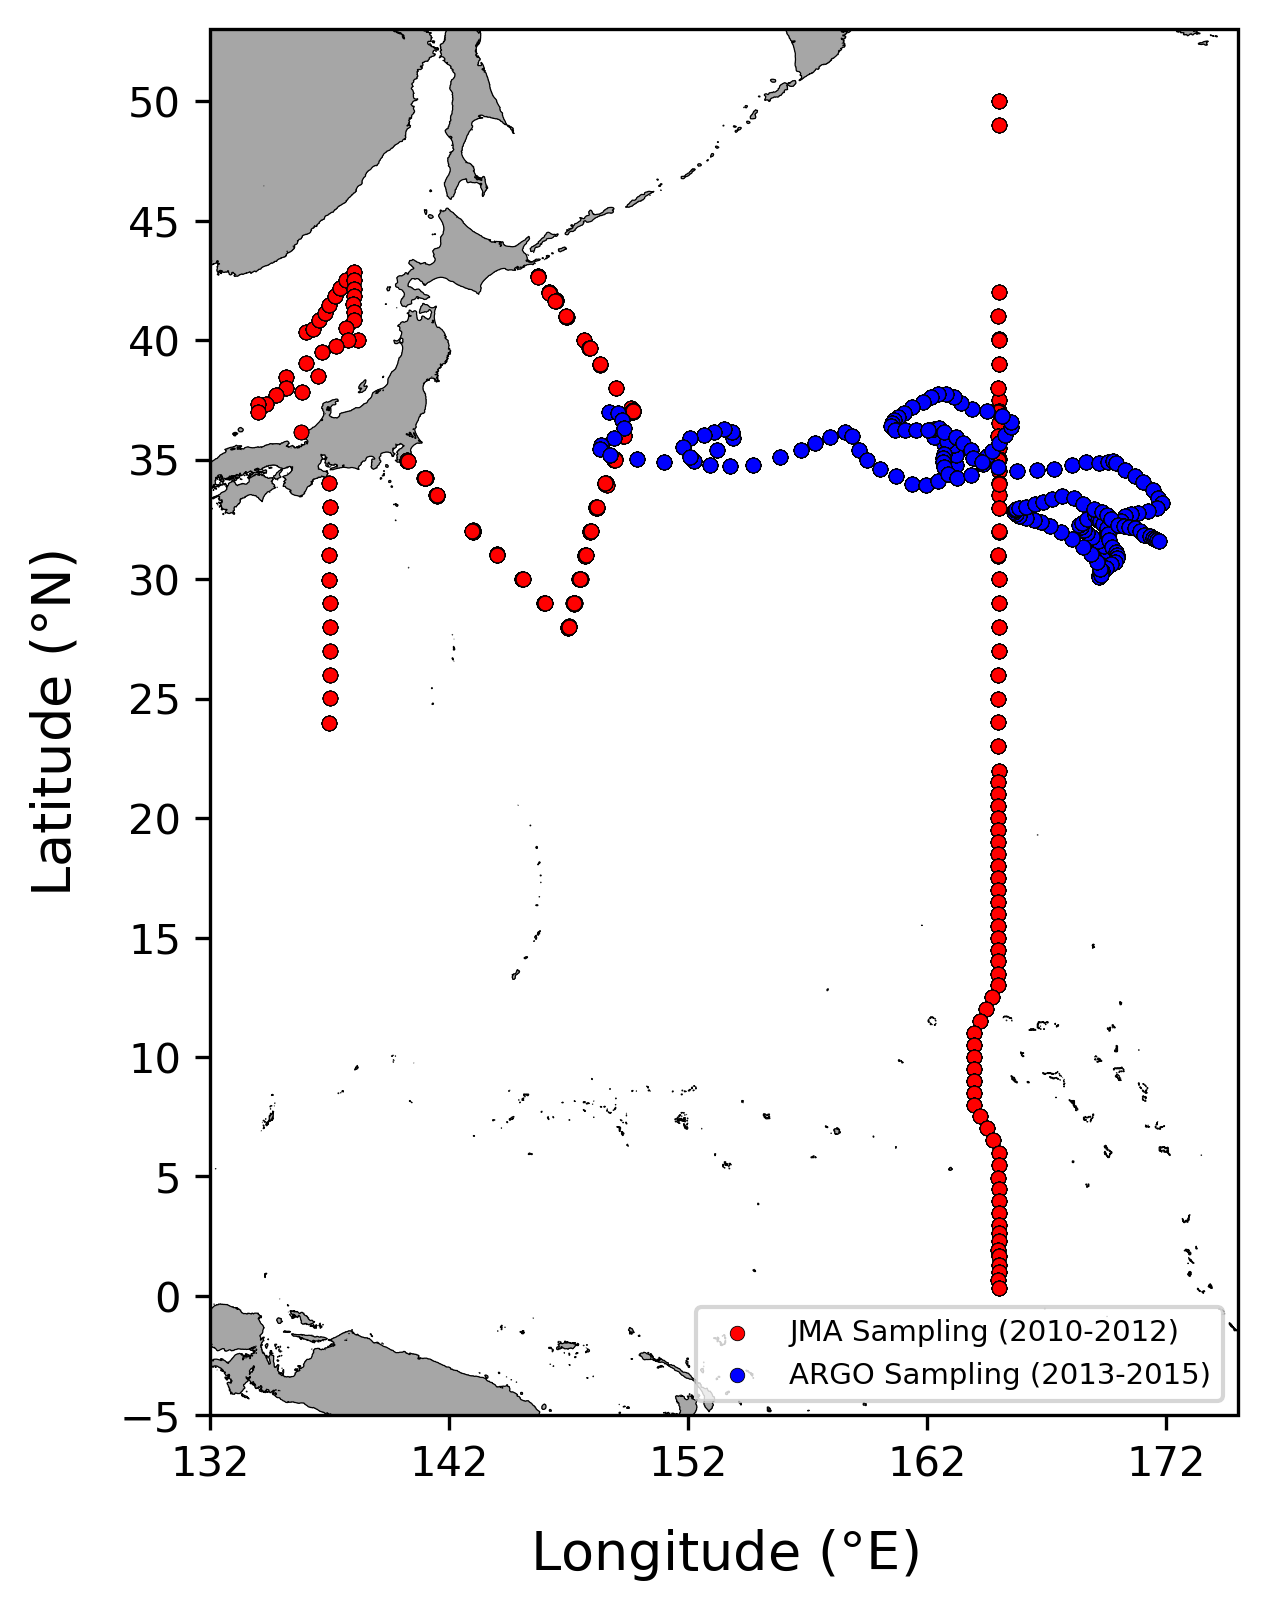

In [15]:
#Plot ARGO and JMA sampling sites onto contour map
#Define Lat and Lons of each Dataset
JMALon=JMA.lon
JMALat=JMA.lat
ARGOLon=ARGO.LON
ARGOLat=ARGO.LAT

FigMap= plt.figure(figsize = (8,6), dpi = 300)

# use girdspec to specify the geometry of the grid that subplots are placed in
gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[0], projection =ccrs.PlateCarree())

#Set boundaries of the map (LonMin,LonMax,LatMin,LatMax)
ax.set_extent([132,175,-5,51])

#Add Tickmarks to Map (min,max,increments) 
ax.set_xticks(np.arange(132,180,10))
ax.set_yticks(np.arange(-5,53,5))

#Add Lat and Lon labels
ax.annotate('Latitude ($\degree$N)',(-0.15,0.5),xycoords = 'axes fraction',va = 'center', ha = 'center', rotation = -270,fontsize=13)
ax.annotate('Longitude ($\degree$E)',(0.5,-0.1), xycoords = 'axes fraction',va = 'center', ha = 'center',fontsize=13)

#Plot basemap with bathymetery using bedrock data as bottom depth but don't color in the land-not necessary but 
#for future reference, unmark below if you want to include it
#bedrock=ax.contourf(bx,by,bathy, levels=[-14000,-12000,-10000,-8000,-6000,-4000,-2000,0],cmap = cmo.cm.ice, vmax=6000, zorder = 1, alpha = 1)

#Distinguish the coastline with a line & color it in
ax.contourf(bx,by,bathy,levels=[0,30000],colors = 'grey',zorder=1,alpha=0.7)
ax.contour(bx,by,bathy,levels=[0],linewidths=0.3,linestyles = '-',colors = 'black',zorder=1,alpha=1)
#I like using the contours because the lines are more detailed than getting from regular basemap

#If you want to add a colorbar for bedrock elevation/depth
#cb=plt.colorbar(bedrock,ax=ax,shrink=0.6)
#cb.set_label('Bottom Depth (m)', fontsize = 13)
#cb.ax.tick_params(labelsize = 10)

#Plot JMA and ARGO sampling sites with latlon data
ax.scatter(JMALon,JMALat,color='red',edgecolors='black',s=12,linewidths=0.2,label="JMA Sampling (2010-2012)")

ax.scatter(ARGOLon,ARGOLat,color='blue',edgecolors='black',s=12,linewidths=0.2, label="ARGO Sampling (2013-2015)")
plt.legend(loc='lower right',prop = {'size' : 7})

#size = FigMap.get_size_inches()*Fig1.dpi # size in pixels
#size

#Save picture to working directory
#FigMap.savefig('JMA_ArgoSamplingSites.png', bbox_inches='tight', dpi=600)

#From this figure, we can see that JMA sampling covers a lot of area, while ARGO is confined to a latitude range (28-38)
#There is some overlap at the 150 E, 36 N and 164 E, 36 N areas.
#The years for each dataset do not overlap- basically we would be using the model to predict nitrate 
#concentration in future years
#(Will help with model accurracy and precison!)

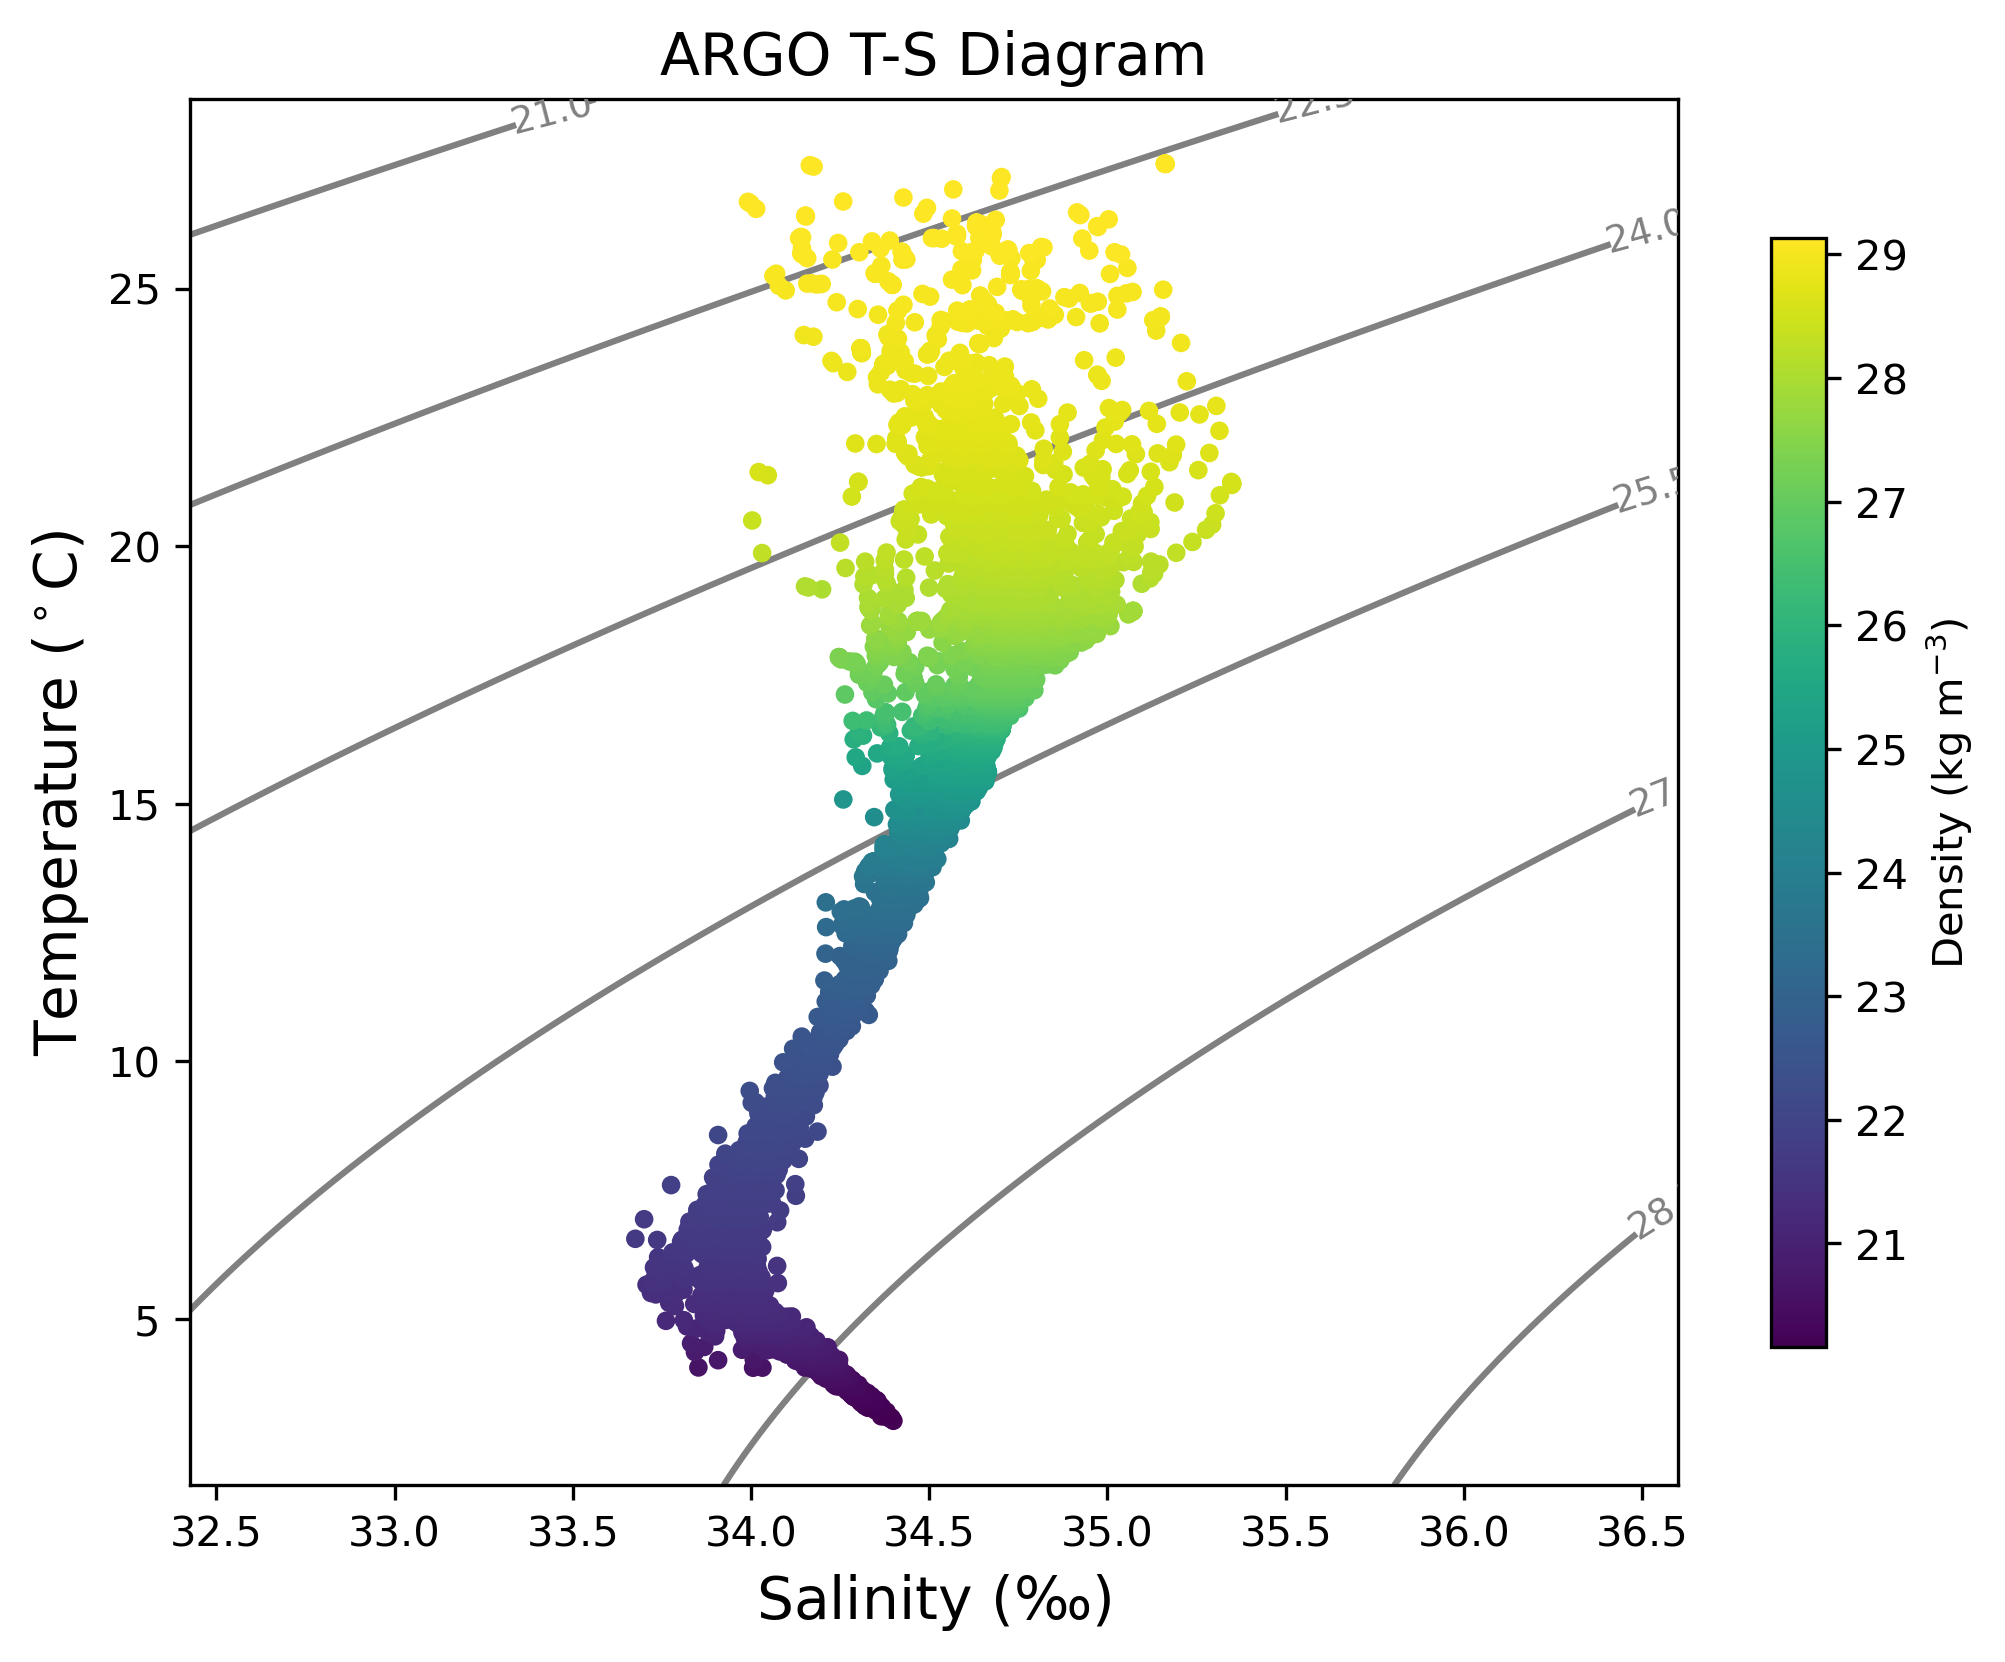

In [16]:
# TS Diagram for ARGO
ARGO_TS=ARGO[['TEMPERATURE[C]', 'SALINITY[PSS]']]

ARGO_df=ARGO_TS.sort_values('TEMPERATURE[C]',ascending=True)

ARGO_mint=np.min(ARGO_df['TEMPERATURE[C]'])
ARGO_maxt=np.max(ARGO_df['TEMPERATURE[C]'])

ARGO_mins=np.min(ARGO_df['SALINITY[PSS]'])
ARGO_maxs=np.max(ARGO_df['SALINITY[PSS]'])

ARGO_tempL=np.linspace(ARGO_mint-1.25,ARGO_maxt+1.25,11144)

ARGO_salL=np.linspace(ARGO_mins-1.25,ARGO_maxs+1.25,11144)

ARGO_Tg, ARGO_Sg = np.meshgrid(ARGO_tempL,ARGO_salL)
ARGO_sigmatheta = gsw.sigma0(ARGO_Sg, ARGO_Tg)
ARGO_cnt = np.linspace(ARGO_sigmatheta.min(), ARGO_sigmatheta.max(),11144)

ARGO_fig,ARGO_ax=plt.subplots(figsize=(8,6),dpi=300)
ARGO_cs = ARGO_ax.contour(ARGO_Sg, ARGO_Tg, ARGO_sigmatheta, colors='grey', zorder=1)

#manual_locations = [(-60, 70)]
ARGO_cl=plt.clabel(ARGO_cs,fontsize=9,inline=True)

ARGO_sc=plt.scatter(ARGO_df['SALINITY[PSS]'], ARGO_df['TEMPERATURE[C]'],c=ARGO_cnt,s=12)

ARGO_cb=plt.colorbar(ARGO_sc,shrink=0.8)

ARGO_ax.set_xlabel('Salinity ($‰$)',fontsize=14)

ARGO_ax.set_ylabel('Temperature ($^\circ$C)',fontsize=14)

ARGO_ax.set_title('ARGO T-S Diagram',fontsize=14)

ARGO_ax.tick_params(direction='out')
ARGO_cb.ax.tick_params(direction='out')
ARGO_cb.set_label('Density (kg m$^{-3}$)')
#plt.tight_layout()
#plt.savefig(‘TS_Argo.png’,format=’png’,dpi=600,transparent=False)
plt.show()


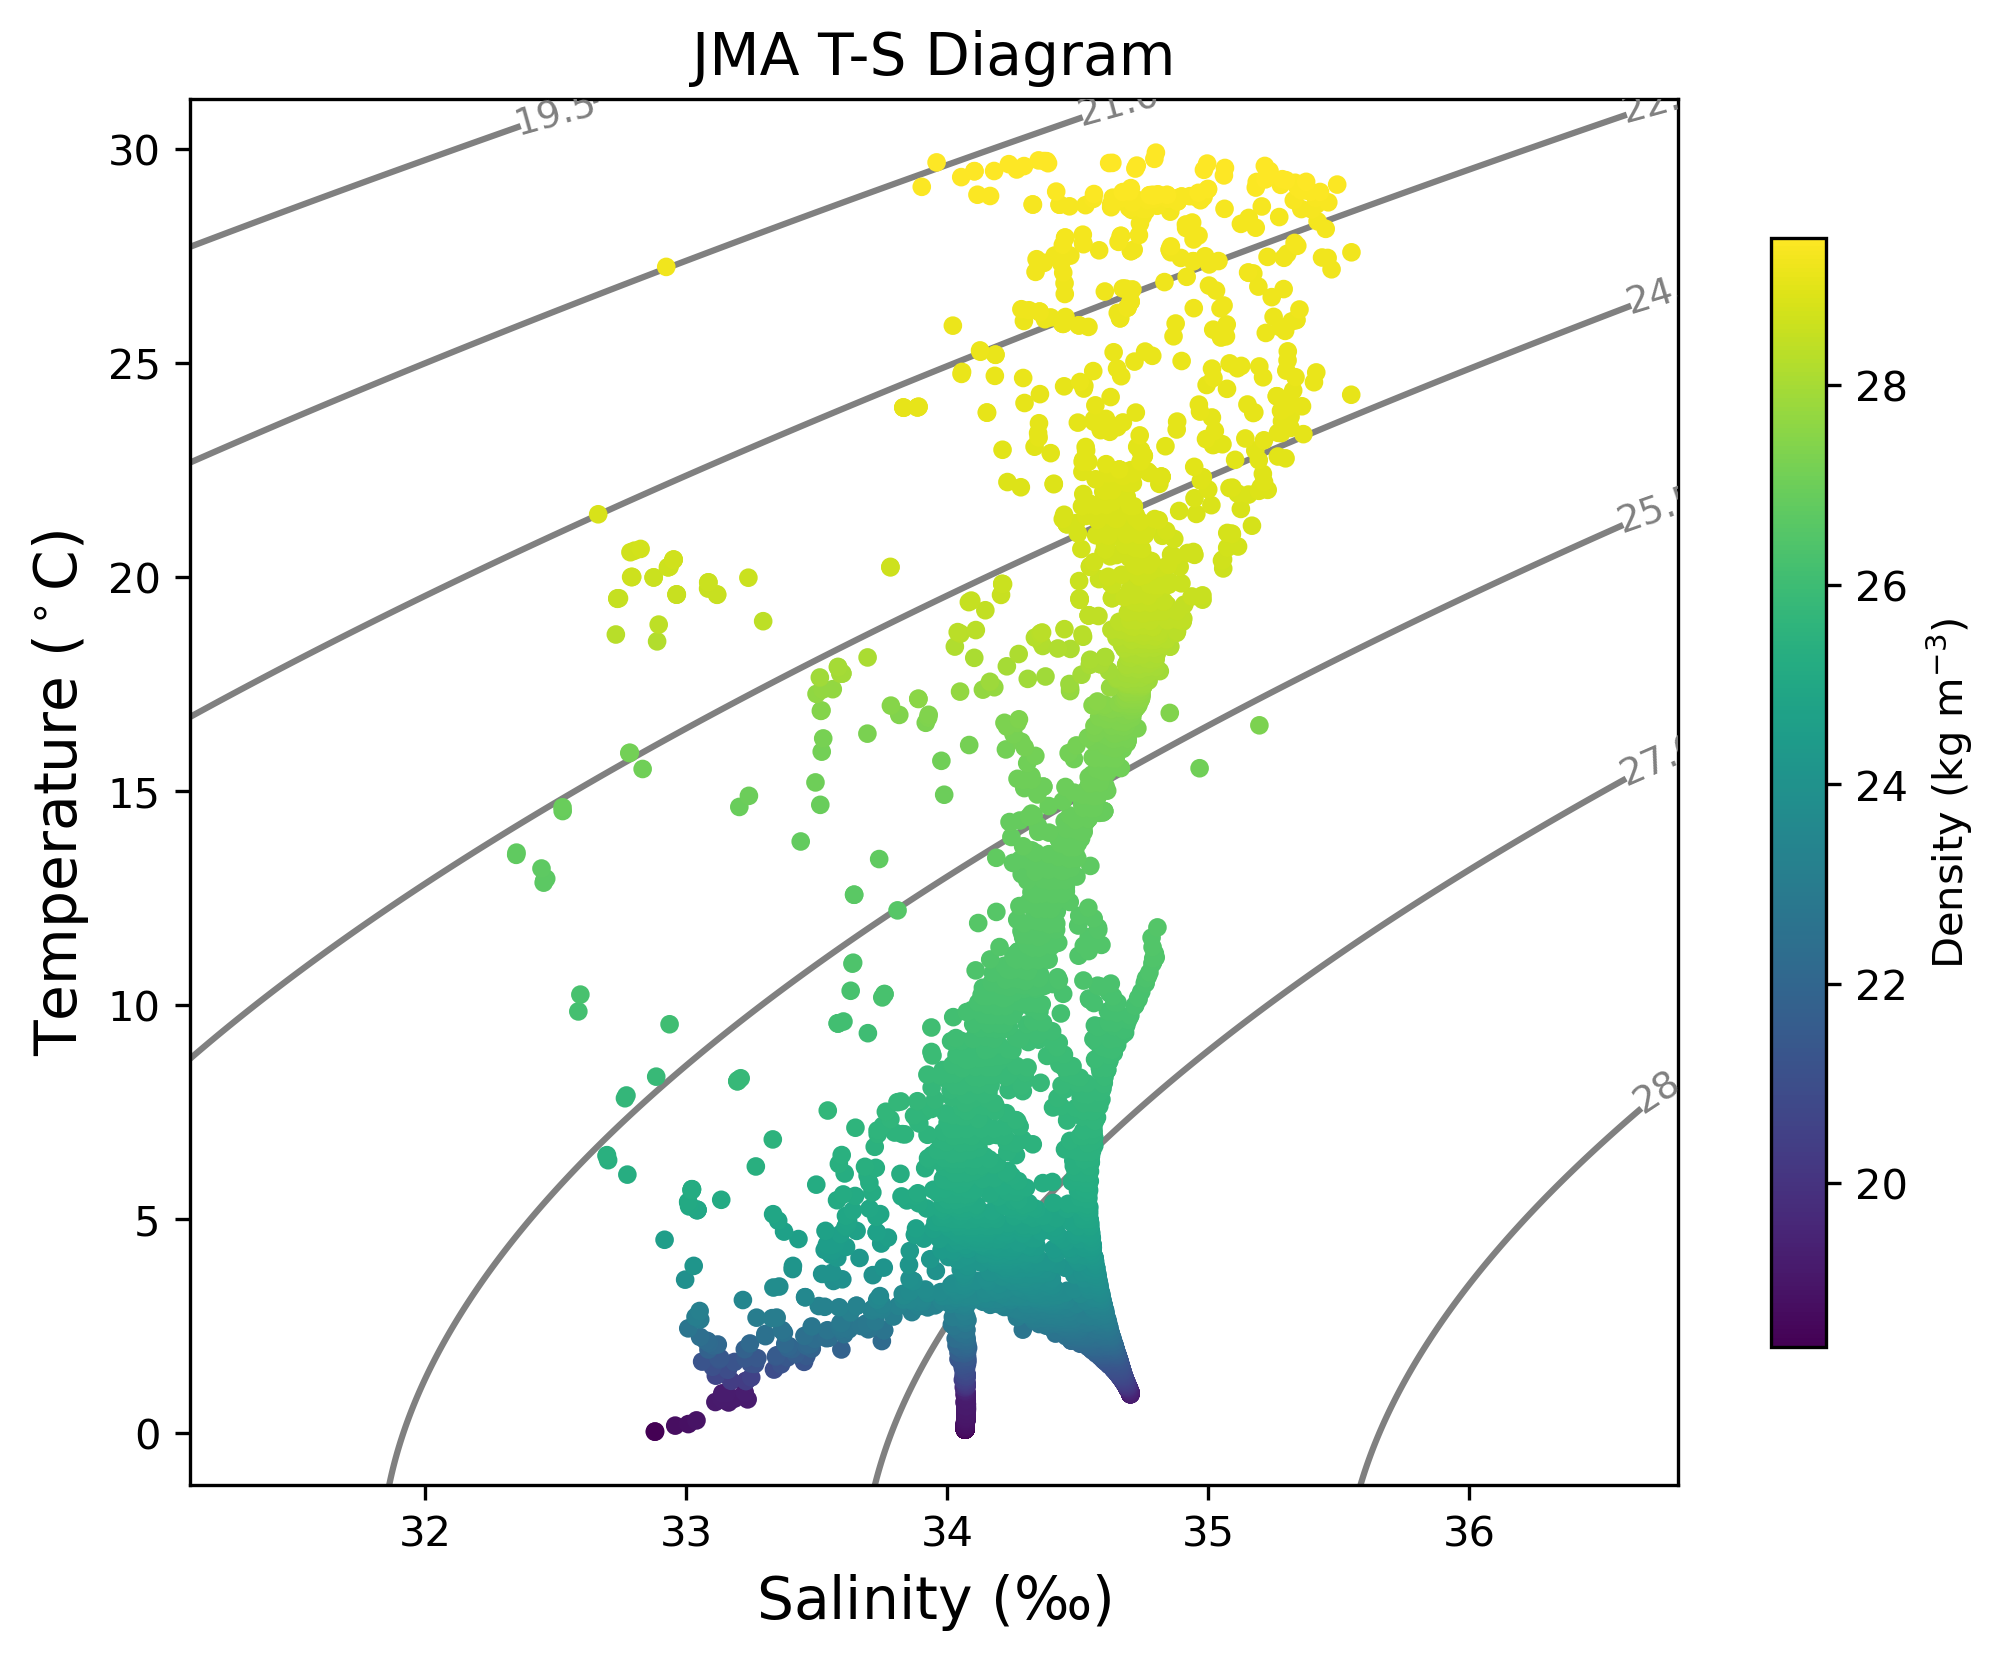

In [17]:
# TS Diagram for JMA
JMA_ts=JMA[['theta', 'sal']]

JMA_df=JMA_ts.sort_values('theta',ascending=True)

JMA_mint=np.min(JMA_df['theta'])
JMA_maxt=np.max(JMA_df['theta'])

JMA_mins=np.min(JMA_df['sal'])
JMA_maxs=np.max(JMA_df['sal'])

JMA_tempL=np.linspace(JMA_mint-1.25,JMA_maxt+1.25,7383)

JMA_salL=np.linspace(JMA_mins-1.25,JMA_maxs+1.25,7383)

JMA_Tg, JMA_Sg = np.meshgrid(JMA_tempL,JMA_salL)
JMA_sigmatheta = gsw.sigma0(JMA_Sg, JMA_Tg)
JMA_cnt = np.linspace(JMA_sigmatheta.min(), JMA_sigmatheta.max(),7383)

JMA_fig,JMA_ax=plt.subplots(figsize=(8,6),dpi=300)
JMA_cs = JMA_ax.contour(JMA_Sg, JMA_Tg, JMA_sigmatheta, colors='grey', zorder=1)

#manual_locations = [(-60, 70)]
JMA_cl=plt.clabel(JMA_cs,fontsize=9,inline=True)

JMA_sc=plt.scatter(JMA_df['sal'], JMA_df['theta'],c=JMA_cnt,s=12)

JMA_cb=plt.colorbar(JMA_sc,shrink=0.8)

JMA_ax.set_xlabel('Salinity ($‰$)',fontsize=14)

JMA_ax.set_ylabel('Temperature ($^\circ$C)',fontsize=14)

JMA_ax.set_title('JMA T-S Diagram',fontsize=14)

JMA_ax.tick_params(direction='out')
JMA_cb.ax.tick_params(direction='out')
JMA_cb.set_label('Density (kg m$^{-3}$)')
#plt.tight_layout()
#plt.savefig(‘TS_JMA.png’,format=’png’,dpi=600,transparent=False)
plt.show()

#Comparing the TS diagrams of both datasets- JMA has a wider range than ARGO, ARGO is more confined. This is good, since the density vs nitrate model
#derived from JMA would cover more ground/increase accuracy & precision of Argo
#Makes sense since JMA as a wider range (latitude & longitude) of sampling sites/larger water mass covered

Text(0.5, 1.0, 'JMA Depth vs Nitrate')

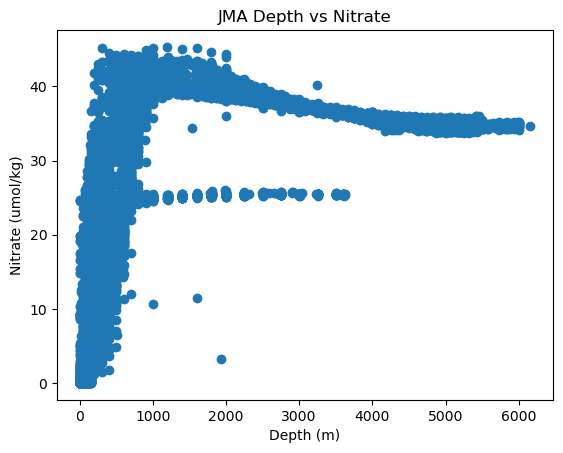

In [18]:
#Checking JMA data
plt.plot(JMA.depth,JMA.nitrate,'o')
plt.xlabel('Depth (m)')
plt.ylabel('Nitrate (umol/kg)')
plt.title('JMA Depth vs Nitrate')

Text(0.5, 1.0, 'JMA Density vs Nitrate')

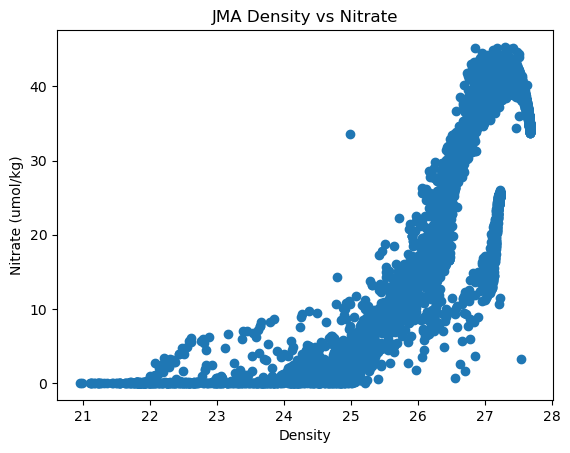

In [19]:
plt.plot(JMA.density,JMA.nitrate,'o')
plt.xlabel('Density')
plt.ylabel('Nitrate (umol/kg)')
plt.title('JMA Density vs Nitrate')

Text(0.5, 1.0, 'JMA Temperature vs Nitrate')

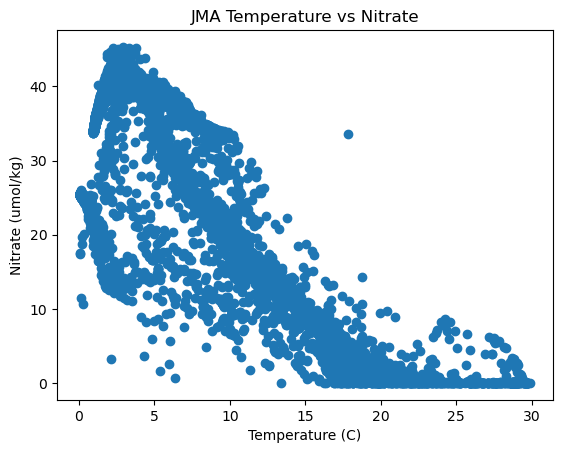

In [20]:
plt.plot(JMA.theta,JMA.nitrate,'o')
plt.xlabel('Temperature (C)')
plt.ylabel('Nitrate (umol/kg)')
plt.title('JMA Temperature vs Nitrate')

Text(0.5, 1.0, 'JMA Salinity vs Nitrate')

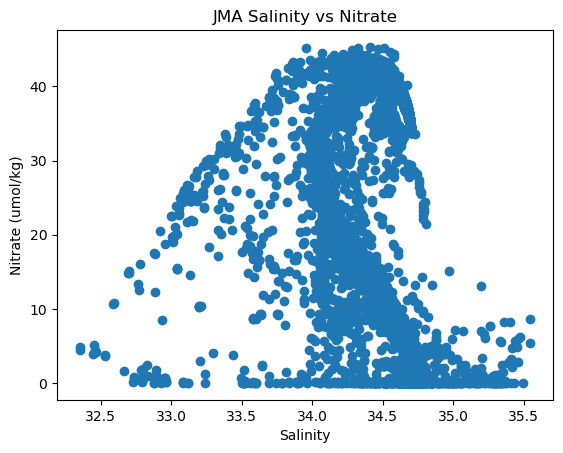

In [21]:
#Checking JMA data
plt.plot(JMA.sal,JMA.nitrate,'o')
plt.xlabel('Salinity')
plt.ylabel('Nitrate (umol/kg)')
plt.title('JMA Salinity vs Nitrate')

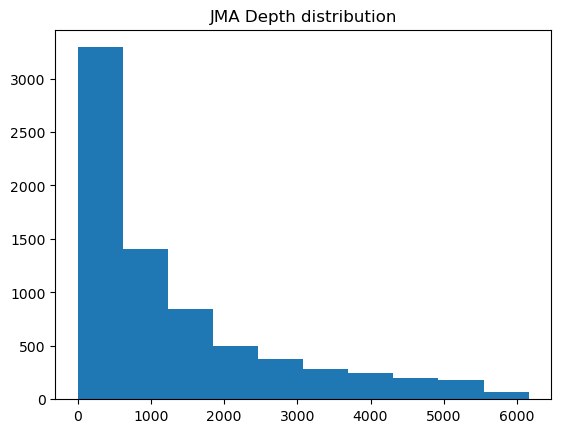

In [22]:
#Since temperature and salinity are related to density, could build a model just off of density.
#Depth doesn't have a linear relationship-hard to graph
#Check if normal distrubution

plt.hist(JMA.depth)
plt.title('JMA Depth distribution')
plt.show()

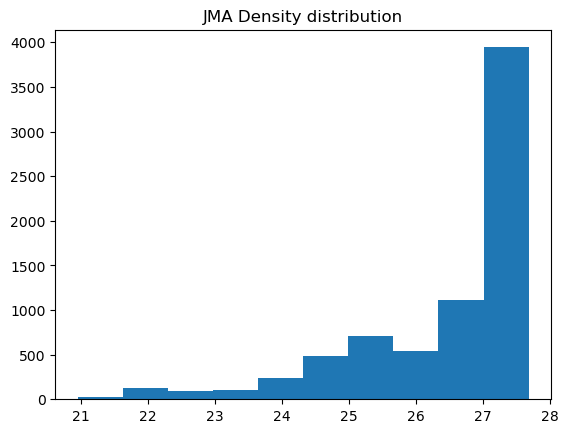

In [23]:
plt.hist(JMA.density)
plt.title('JMA Density distribution')
plt.show()

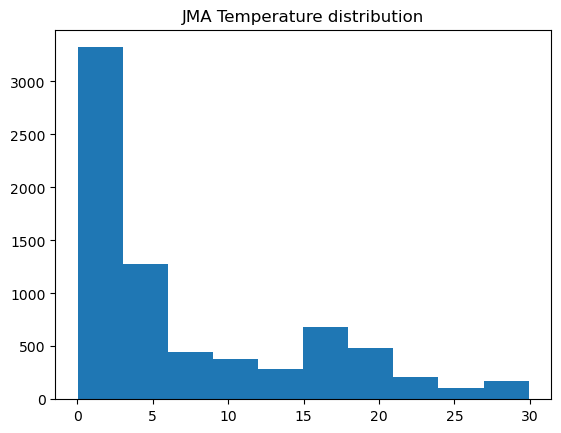

In [24]:
plt.hist(JMA.theta)
plt.title('JMA Temperature distribution')
plt.show()

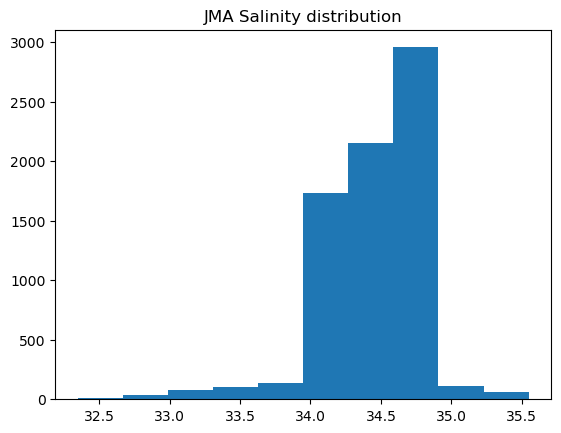

In [25]:
plt.hist(JMA.sal)
plt.title('JMA Salinity distribution')
plt.show()

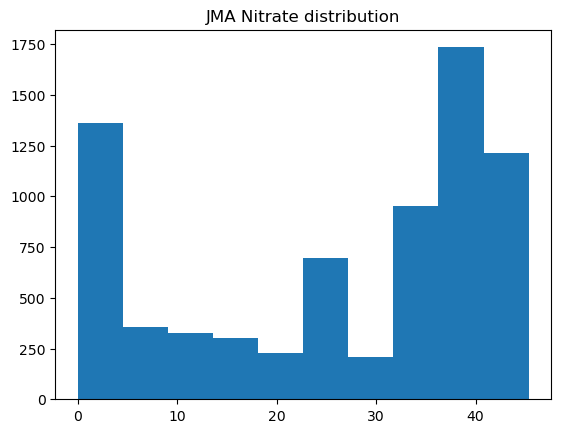

In [26]:
plt.hist(JMA.nitrate)
plt.title('JMA Nitrate distribution')
plt.show()

#None of the JMA variables are normally distributed based off of histogram 
#Depth- left skewed- lots of surface sampling
#Density- right skewed
#Temperature & Nitrate- Bimodal
#Salinity-almost looks like a gaussian curve but slightly skewed to the right. This value makes sense however since typical values should be between
# 34 ppt-36 ppt. Since the other data is not normally distributed, we have to use non-parametric testing anyway.

# Could also do Qualtile-Qualtile Plot or Shapiro-Wilk tests to double check but it's obvious by looking at the data visually with the histograms

In [27]:
# Non-Parametric Correlation Tests- adapted from HW2
#Spearman's Correlation coefficient is used 
# This summarizes strength between two data samples. Calculated via relative rank of values for each sample
#looking at correlations between nitrate & other variables

from numpy.random import seed
from scipy.stats import spearmanr

# seed random number generator
seed(1)

# calculate spearman's correlation
# p < 0.05 =significant correlation
# positive rho = positive correlation
# negative rho = negative correlation
J_Nit=JMA.nitrate
J_Den=JMA.density
J_Dep=JMA.depth
J_Temp=JMA.theta
J_Sal=JMA.sal
rho1,p1 = spearmanr(J_Den, J_Nit,alternative='two-sided')
print('Density vs Nitrate: p= %.6f, rho=%.3f' % (p1,rho1))

rho2,p2 = spearmanr(J_Dep, J_Nit,alternative='two-sided')
print('Depth vs Nitrate: p= %.6f, rho=%.3f' % (p2,rho2))

rho3,p3 = spearmanr(J_Temp, J_Nit,alternative='two-sided')
print('Temperature vs Nitrate: p= %.6f, rho=%.3f' % (p3,rho3))

rho4,p4 = spearmanr(J_Sal, J_Nit,alternative='two-sided')
print('Salinity vs Nitrate: p= %.6f, rho=%.3f' % (p4,rho4))

Value={'Test':['Density vs Nitrate','Depth vs Nitrate','Temperature vs Nitrate','Salinity vs Nitrate'], 
       'Rho':[rho1,rho2,rho3,rho4], 'P-value':[p1,p2,p3,p4],'Significant':['Yes','Yes','Yes','Yes']}
SpearmanTestResult=pd.DataFrame(Value)
SpearmanTestResult

#All were significant using nonparametric testing
#As Density increases, Nitrate increases
#Depth increases, Nitrate increases (between 0 m to 1000 m there is a sharp incline then it levels out
#Temperature increases, Nitrate decreases
#Salinity increases, Nitrate decreases (harder to see this relationship visually-take with a grain of salt as 
#salinity did not go below 18)

Density vs Nitrate: p= 0.000000, rho=0.743
Depth vs Nitrate: p= 0.000000, rho=0.700
Temperature vs Nitrate: p= 0.000000, rho=-0.584
Salinity vs Nitrate: p= 0.000000, rho=-0.192


Test       Rho       P-value Significant
0      Density vs Nitrate  0.742732  0.000000e+00         Yes
1        Depth vs Nitrate  0.700448  0.000000e+00         Yes
2  Temperature vs Nitrate -0.584049  0.000000e+00         Yes
3     Salinity vs Nitrate -0.192309  1.921820e-62         Yes

In [28]:
#Radius Neighbors Regressor
#The data when plotted does not seem linear (see above cells)
#-use nonlinear methods for best model accuracy & precision

#sklearn package
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

y = JMA.nitrate
X=JMA[['density','depth']]
X_temp = JMA[['theta']]
X_dep = JMA[['depth']]
X_den = JMA[['density']]
X_sal = JMA[['sal']]

In [29]:
##For depth and density together
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2,random_state=4)

from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
standx_train = scalerX.transform(X_train)
standx_test = scalerX.transform(X_test)


#Having them as dataframes (same type) makes it easier to plot
standX_train=pd.DataFrame(standx_train)
standX_test=pd.DataFrame(standx_test)

y_train=pd.DataFrame(Y_train)
y_test=pd.DataFrame(Y_test)


#Since there is 2 x variables, have to plot them seperately!
standX_train1st=standX_train[0]
standX_train2nd=standX_train[1]

standX_test1st=standX_test[0]
standX_test2nd=standX_test[1]



Choose a number for radius:  0.14


R^2 score: 0.95


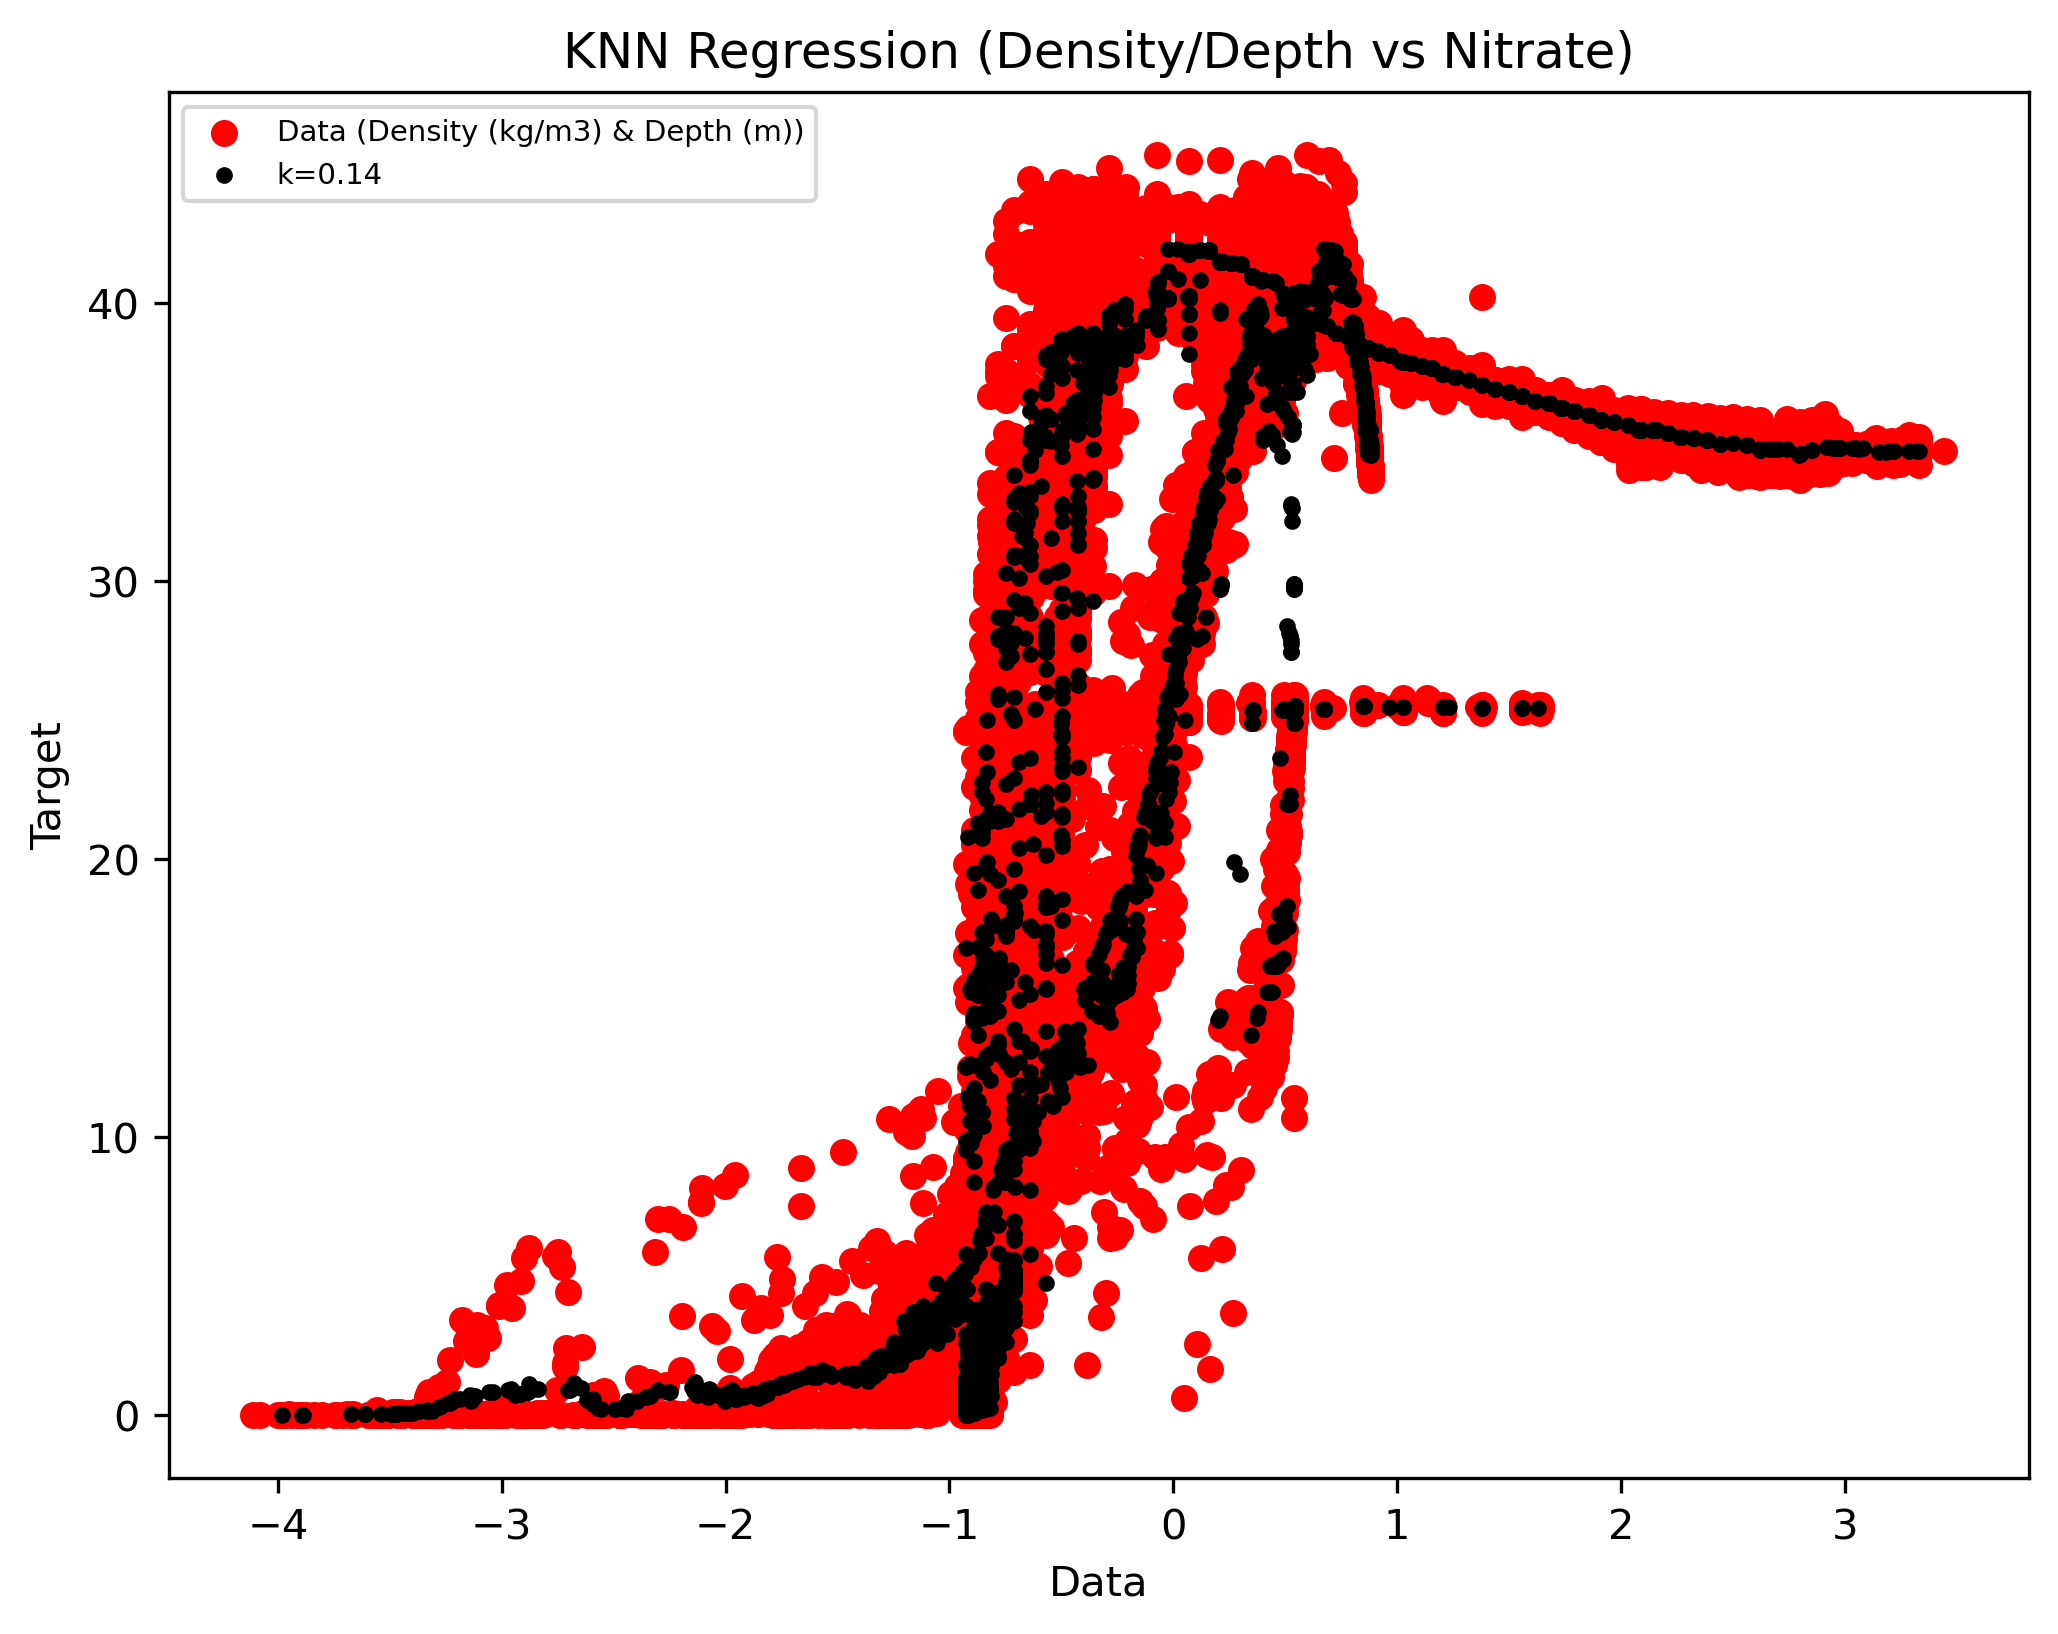

In [30]:
### NONLINEAR DEPTH & DENSITY VS NITRATE (two variables- since salinity and temperature are redundant, we can just use density as the varaible with depth)
n  = float(input('Choose a number for radius: '))

# Import the necessary modules and libraries
from sklearn.neighbors import RadiusNeighborsRegressor

# Fit regression model
regr = RadiusNeighborsRegressor(radius=n)
regr.fit(standX_train, y_train)

R2dendep=regr.score(standX_train, y_train)
print("R^2 score: {0:.2f}".format(regr.score(standX_train, y_train)))
# Predict (standardized_X_test)
ytestpred1 = regr.predict(standX_test)
ytestpred=pd.DataFrame(ytestpred1)
#Use radius=0.14
ytestpred
# Plot the results
Fig1= plt.figure(figsize = (8,6), dpi = 300)

#since there is multiple x variables, need to separate the scatterplots
plt.scatter(standX_train1st, y_train, c="red", label="Data (Density (kg/m3) & Depth (m))",s=30)
plt.scatter(standX_train2nd, y_train, c="red",s=30)

plt.scatter(standX_test1st, ytestpred, color="black", label="k="+str(n), s=9)
plt.scatter(standX_test2nd, ytestpred, color="black",s=9)

plt.xlabel("Data")
plt.ylabel("Target")

plt.title("KNN Regression (Density/Depth vs Nitrate)")
plt.legend(loc='upper left',prop = {'size' : 7})
plt.show()

#Fig1.savefig('KNNDenDepth_Reg.png',format='png',dpi=600,transparent=False)

#Best fit=0.14

In [31]:
#### Temperature vs Nitrate
#in parenthesis (X,y,test_size=0.2,random_state=4), replace X values with above individually
Xtemp_train,Xtemp_test,ytemp_train,ytemp_test = train_test_split(X_temp,y,test_size=0.2,random_state=4)

#Need to scale data first
#scale data
#subtract mean divide by sp

from sklearn.preprocessing import StandardScaler
scalertemp = StandardScaler().fit(Xtemp_train)
standXtemp_train = scalertemp.transform(Xtemp_train)
standXtemp_test = scalertemp.transform(Xtemp_test)


Choose a number for radius:  0.011


R^2 score: 0.90


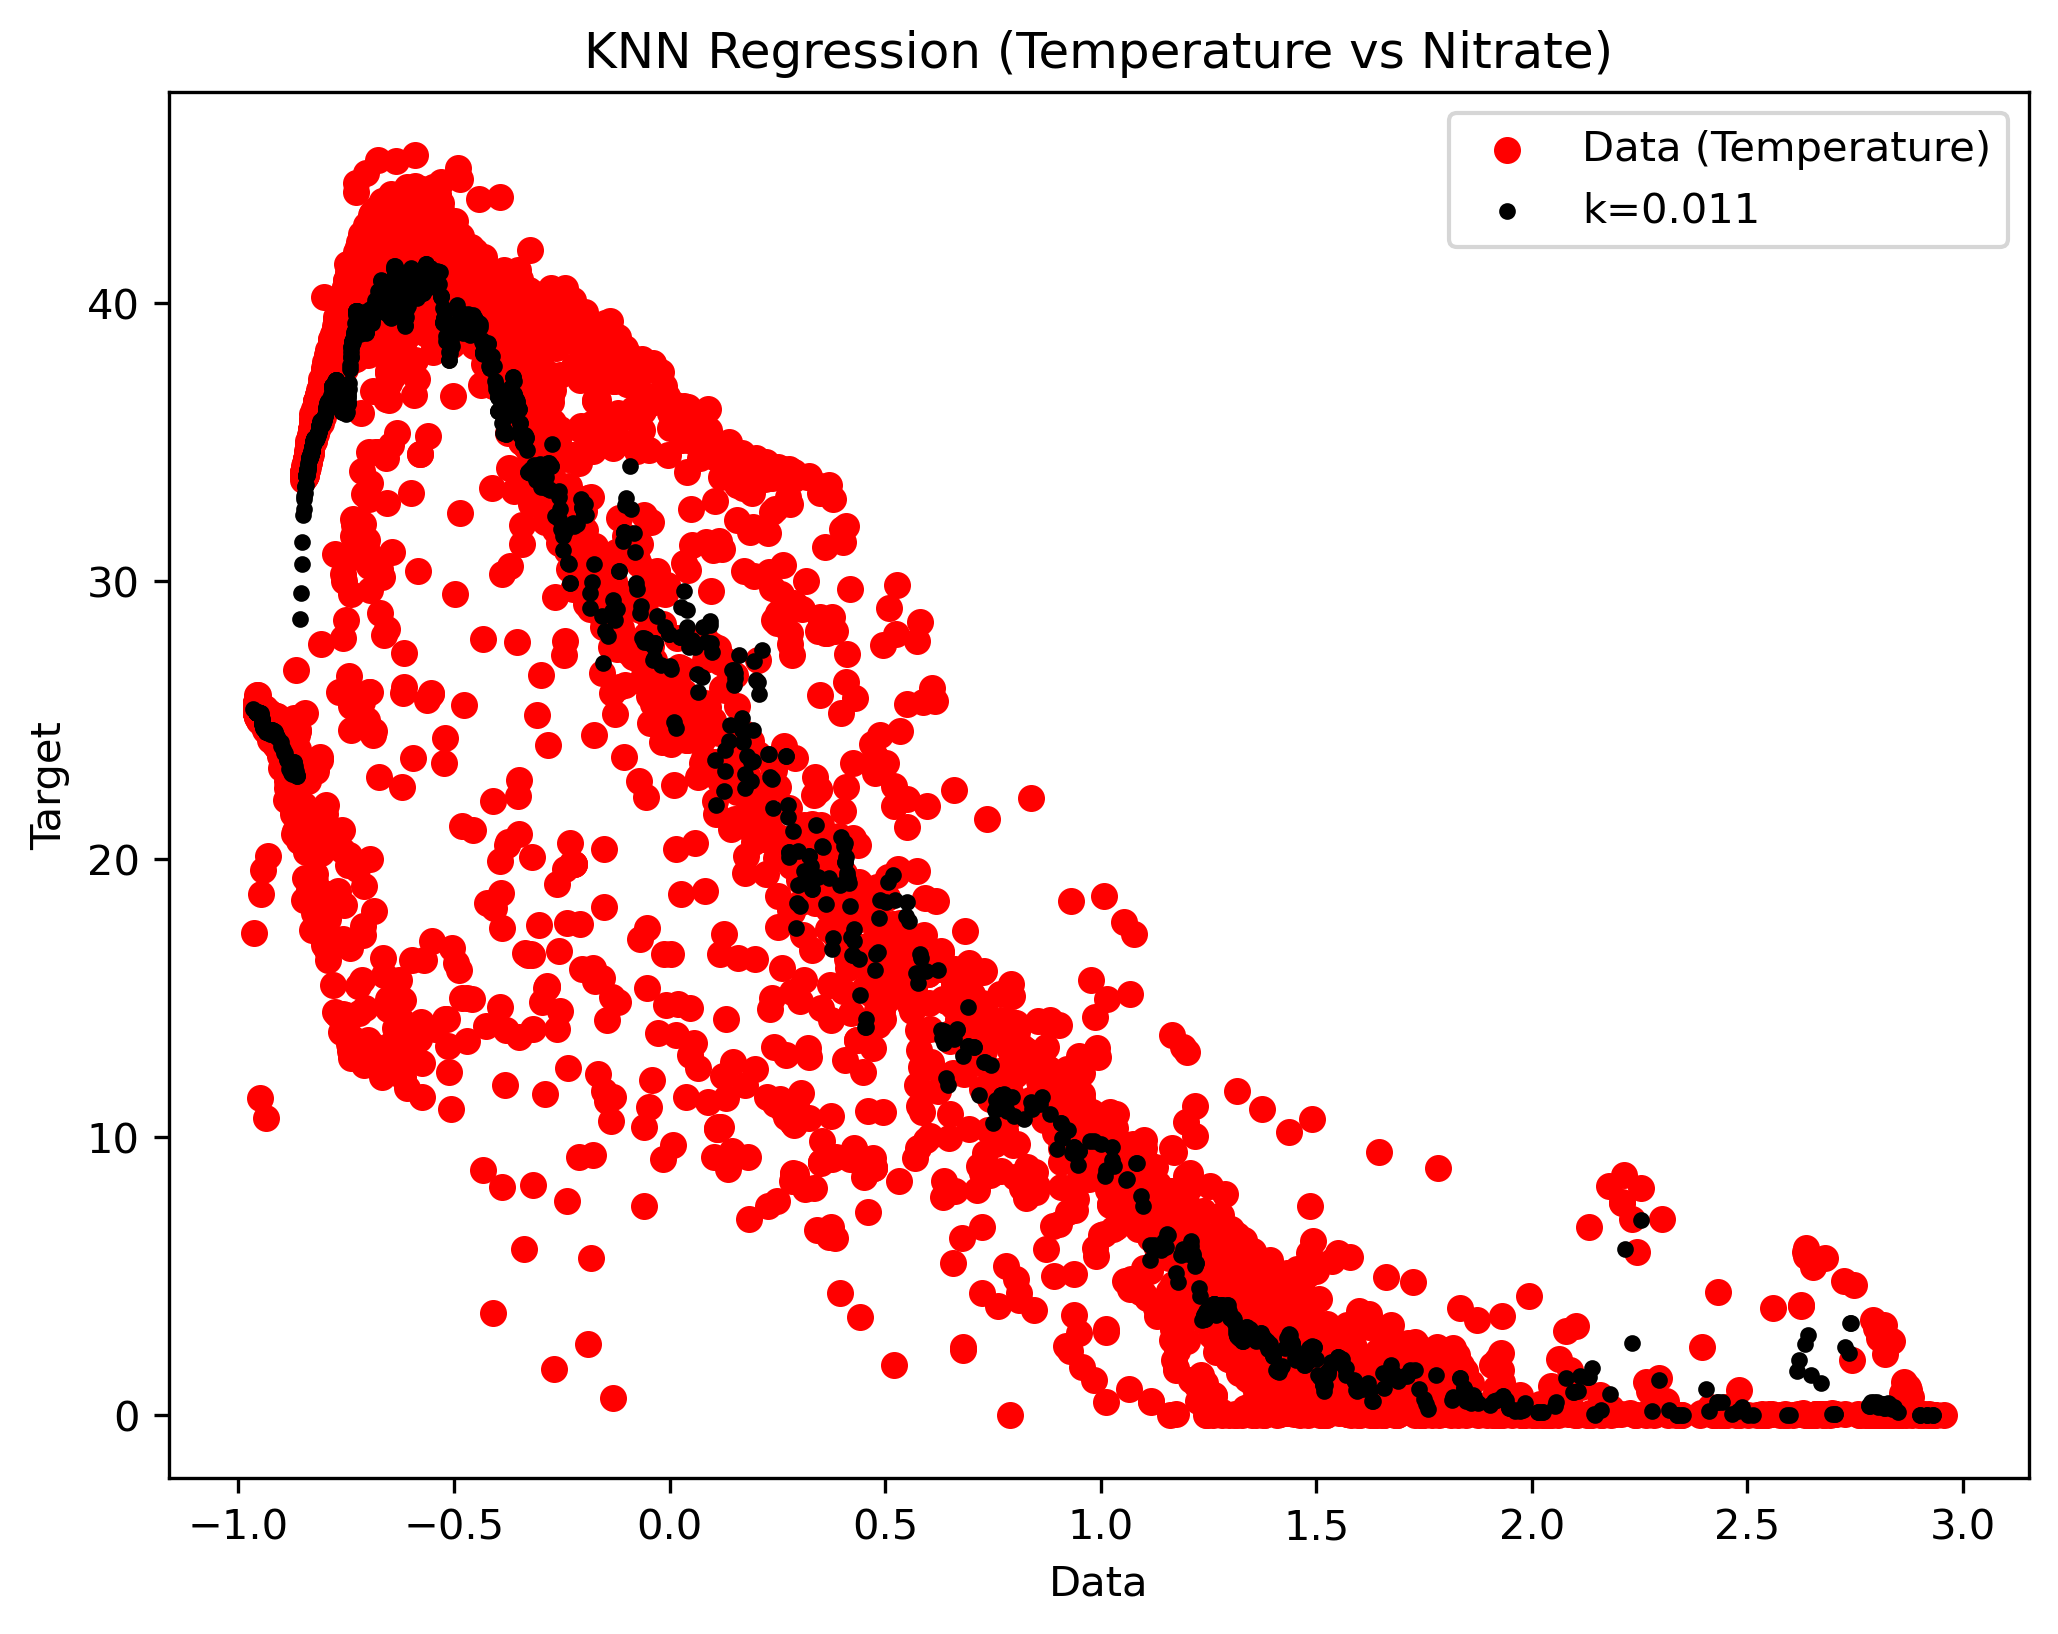

In [32]:
### NONLINEAR TEMP VS NITRATE
n  = float(input('Choose a number for radius: '))

# Import the necessary modules and libraries
from sklearn.neighbors import RadiusNeighborsRegressor


# Fit regression model
regr_1 = RadiusNeighborsRegressor(radius=n)
regr_1.fit(standXtemp_train, ytemp_train)
print("R^2 score: {0:.2f}".format(regr_1.score(standXtemp_train, ytemp_train)))
# Predict (standardized_X_test)
ytest_temp = regr_1.predict(standXtemp_test)
# Plot the results
Fig2= plt.figure(figsize = (8,6), dpi = 300)
plt.scatter(standXtemp_train, ytemp_train, c="red", label="Data (Temperature)",s=30)
plt.scatter(standXtemp_test, ytest_temp, color="black", label="k="+str(n), s=9)
plt.xlabel("Data")
plt.ylabel("Target")

plt.title("KNN Regression (Temperature vs Nitrate)")
plt.legend()
plt.show()

#Fig2.savefig(‘KNNtemp_Reg.png’,format=’png’,dpi=600,transparent=False)

#Best fit=0.011 

In [33]:
#Salinity vs Nitrate
#in parenthesis (X,y,test_size=0.2,random_state=4), replace X values with above individually
Xsal_train,Xsal_test,ysal_train,ysal_test = train_test_split(X_sal,y,test_size=0.2,random_state=4)

#randomstate=4- allowing people to reproduce what you have done

#Need to scale data first
#scale data
#subtract mean divide by sp

from sklearn.preprocessing import StandardScaler
scalersal = StandardScaler().fit(Xsal_train)
standXsal_train = scalersal.transform(Xsal_train)
standXsal_test = scalersal.transform(Xsal_test)

Choose a number for radius:  0.091


R^2 score: 0.35


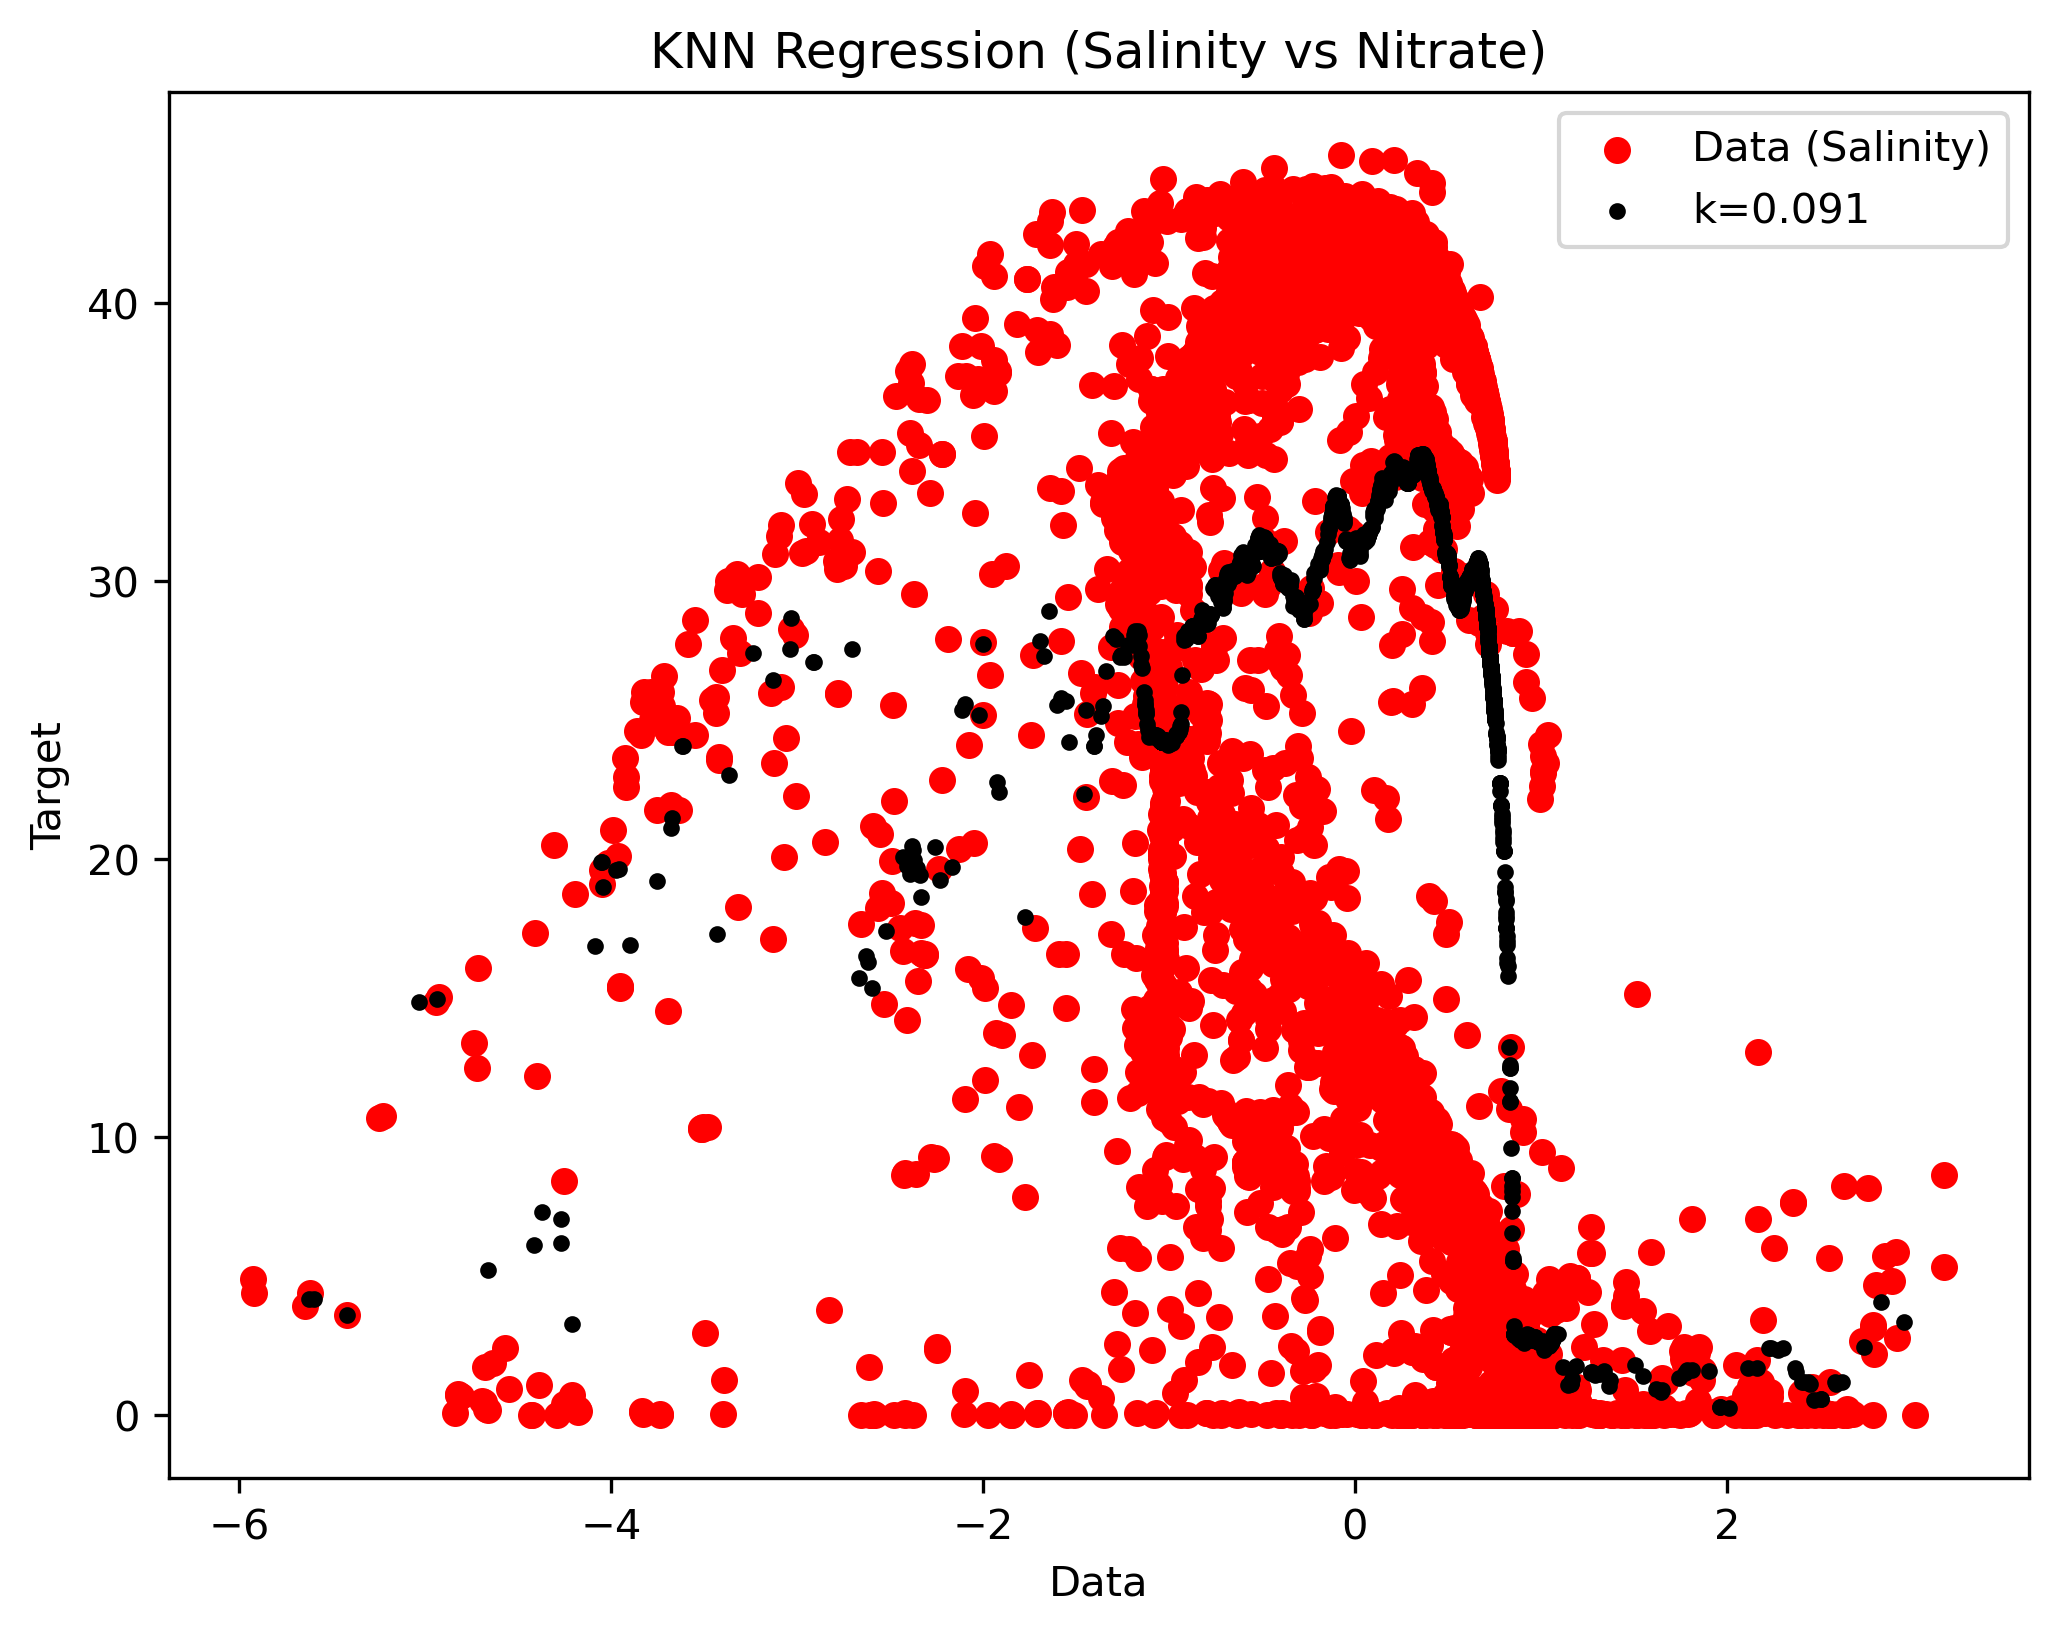

In [34]:
### NONLINEAR SALINITY VS NITRATE
n  = float(input('Choose a number for radius: '))

# Import the necessary modules and libraries
from sklearn.neighbors import RadiusNeighborsRegressor

# Fit regression model
regr_2 = RadiusNeighborsRegressor(radius=n)
regr_2.fit(standXsal_train, ysal_train)
print("R^2 score: {0:.2f}".format(regr_2.score(standXsal_train, ysal_train)))

# Predict (standardized_X_test)
ytest_sal = regr_2.predict(standXsal_test)

# Plot the results
Fig3= plt.figure(figsize = (8,6), dpi = 300)
plt.scatter(standXsal_train, ysal_train, c="red", label="Data (Salinity)",s=30)
plt.scatter(standXsal_test, ytest_sal, color="black", label="k="+str(n), s=9)
plt.xlabel("Data")
plt.ylabel("Target")

plt.title("KNN Regression (Salinity vs Nitrate)")
plt.legend()
plt.show()

#Fig3.savefig(‘KNNsal_Reg.png’,format=’png’,dpi=600,transparent=False)

#Best fit:0.091
#Salinity isn't a very good model :(

In [35]:
#Density vs Nitrate
#in parenthesis (X,y,test_size=0.2,random_state=4), replace X values with above individually
Xden_train,Xden_test,yden_train,yden_test = train_test_split(X_den,y,test_size=0.2,random_state=4)

#randomstate=4- allowing people to reproduce what you have done

#Need to scale data first
#scale data
#subtract mean divide by sp

from sklearn.preprocessing import StandardScaler
scalerden = StandardScaler().fit(Xden_train)
standXden_train = scalerden.transform(Xden_train)
standXden_test = scalerden.transform(Xden_test)

Choose a number for radius:  0.020


R^2 score: 0.91


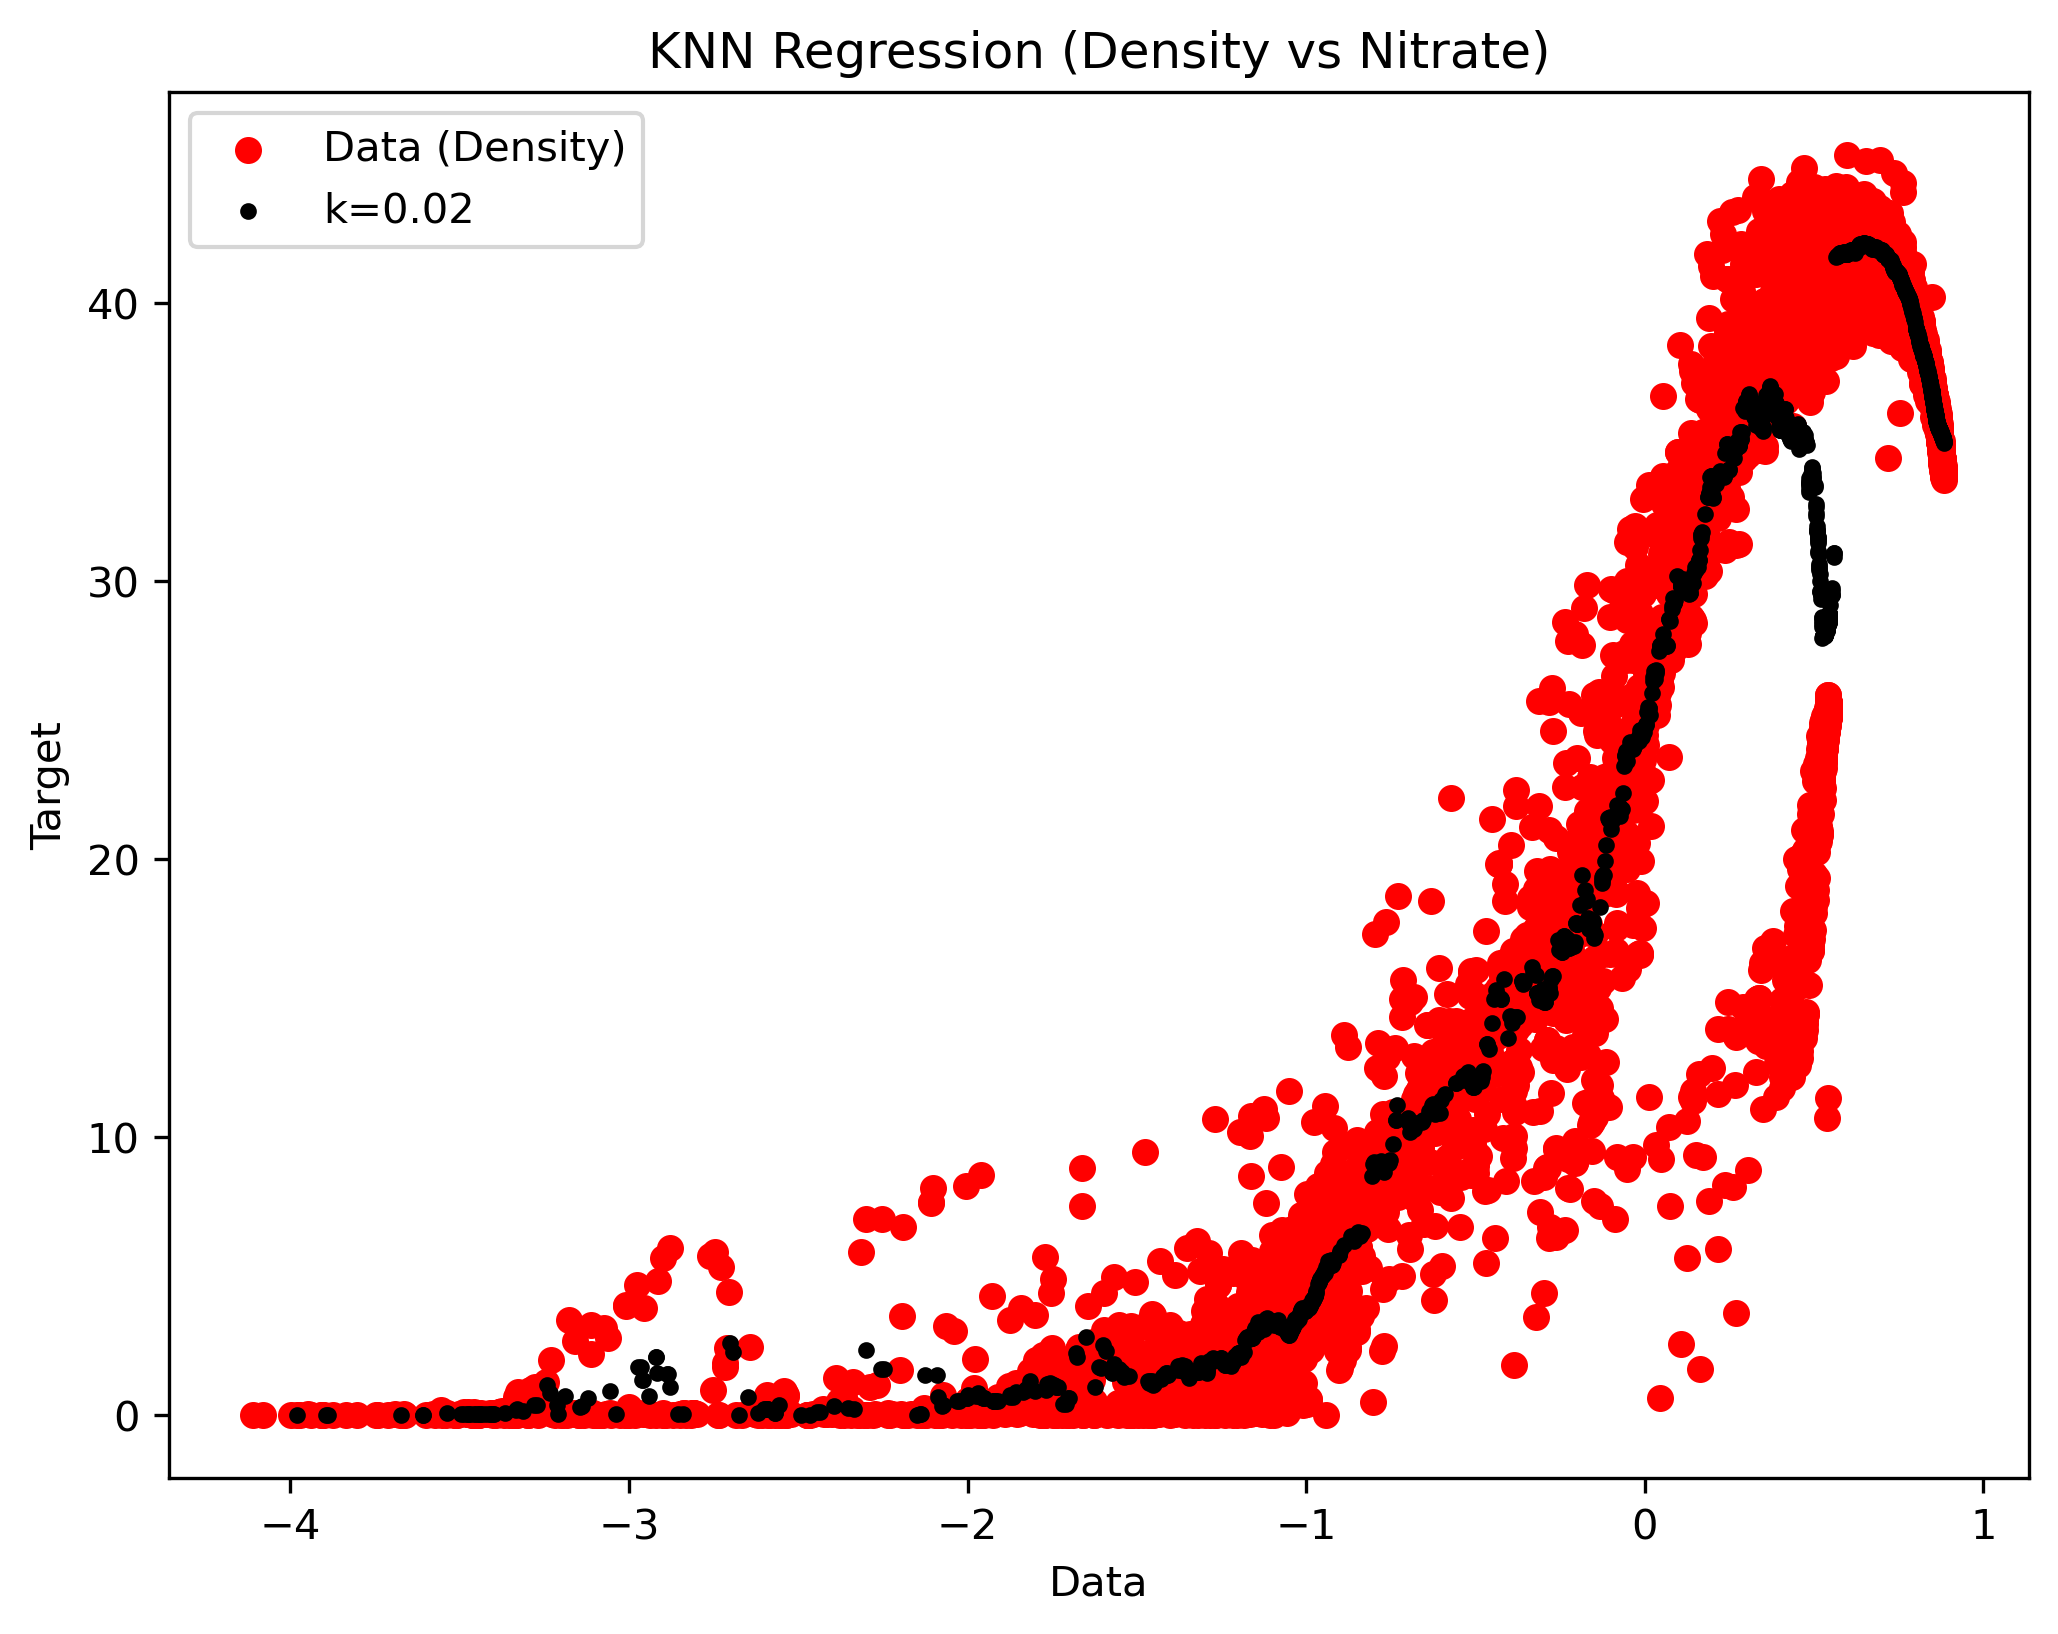

In [36]:
### NONLINEAR DENSITY VS NITRATE
n  = float(input('Choose a number for radius: '))

# Import the necessary modules and libraries
from sklearn.neighbors import RadiusNeighborsRegressor



# Fit regression model
regr_3 = RadiusNeighborsRegressor(radius=n)
regr_3.fit(standXden_train, yden_train)
print("R^2 score: {0:.2f}".format(regr_3.score(standXden_train, yden_train)))

# Predict (standardized_X_test)
ytest_den = regr_3.predict(standXden_test)

# Plot the results
Fig4= plt.figure(figsize = (8,6), dpi = 300)
plt.scatter(standXden_train, yden_train, c="red", label="Data (Density)",s=30)
plt.scatter(standXden_test, ytest_den, color="black", label="k="+str(n), s=9)
plt.xlabel("Data")
plt.ylabel("Target")

plt.title("KNN Regression (Density vs Nitrate)")
plt.legend()
plt.show()

#Fig4.savefig(‘KNNdensity_Reg.png’,format=’png’,dpi=600,transparent=False)

#Best fit:r=0.020


In [37]:
#Depth vs Nitrate
#in parenthesis (X,y,test_size=0.2,random_state=4), replace X values with above individually
Xdep_train,Xdep_test,ydep_train,ydep_test = train_test_split(X_dep,y,test_size=0.2,random_state=4)

#Need to scale data first
#scale data
#subtract mean divide by sp

from sklearn.preprocessing import StandardScaler
scalerdep = StandardScaler().fit(Xdep_train)
standXdep_train = scalerdep.transform(Xdep_train)
standXdep_test = scalerdep.transform(Xdep_test)

Choose a number for radius:  0.027


R^2 score: 0.81


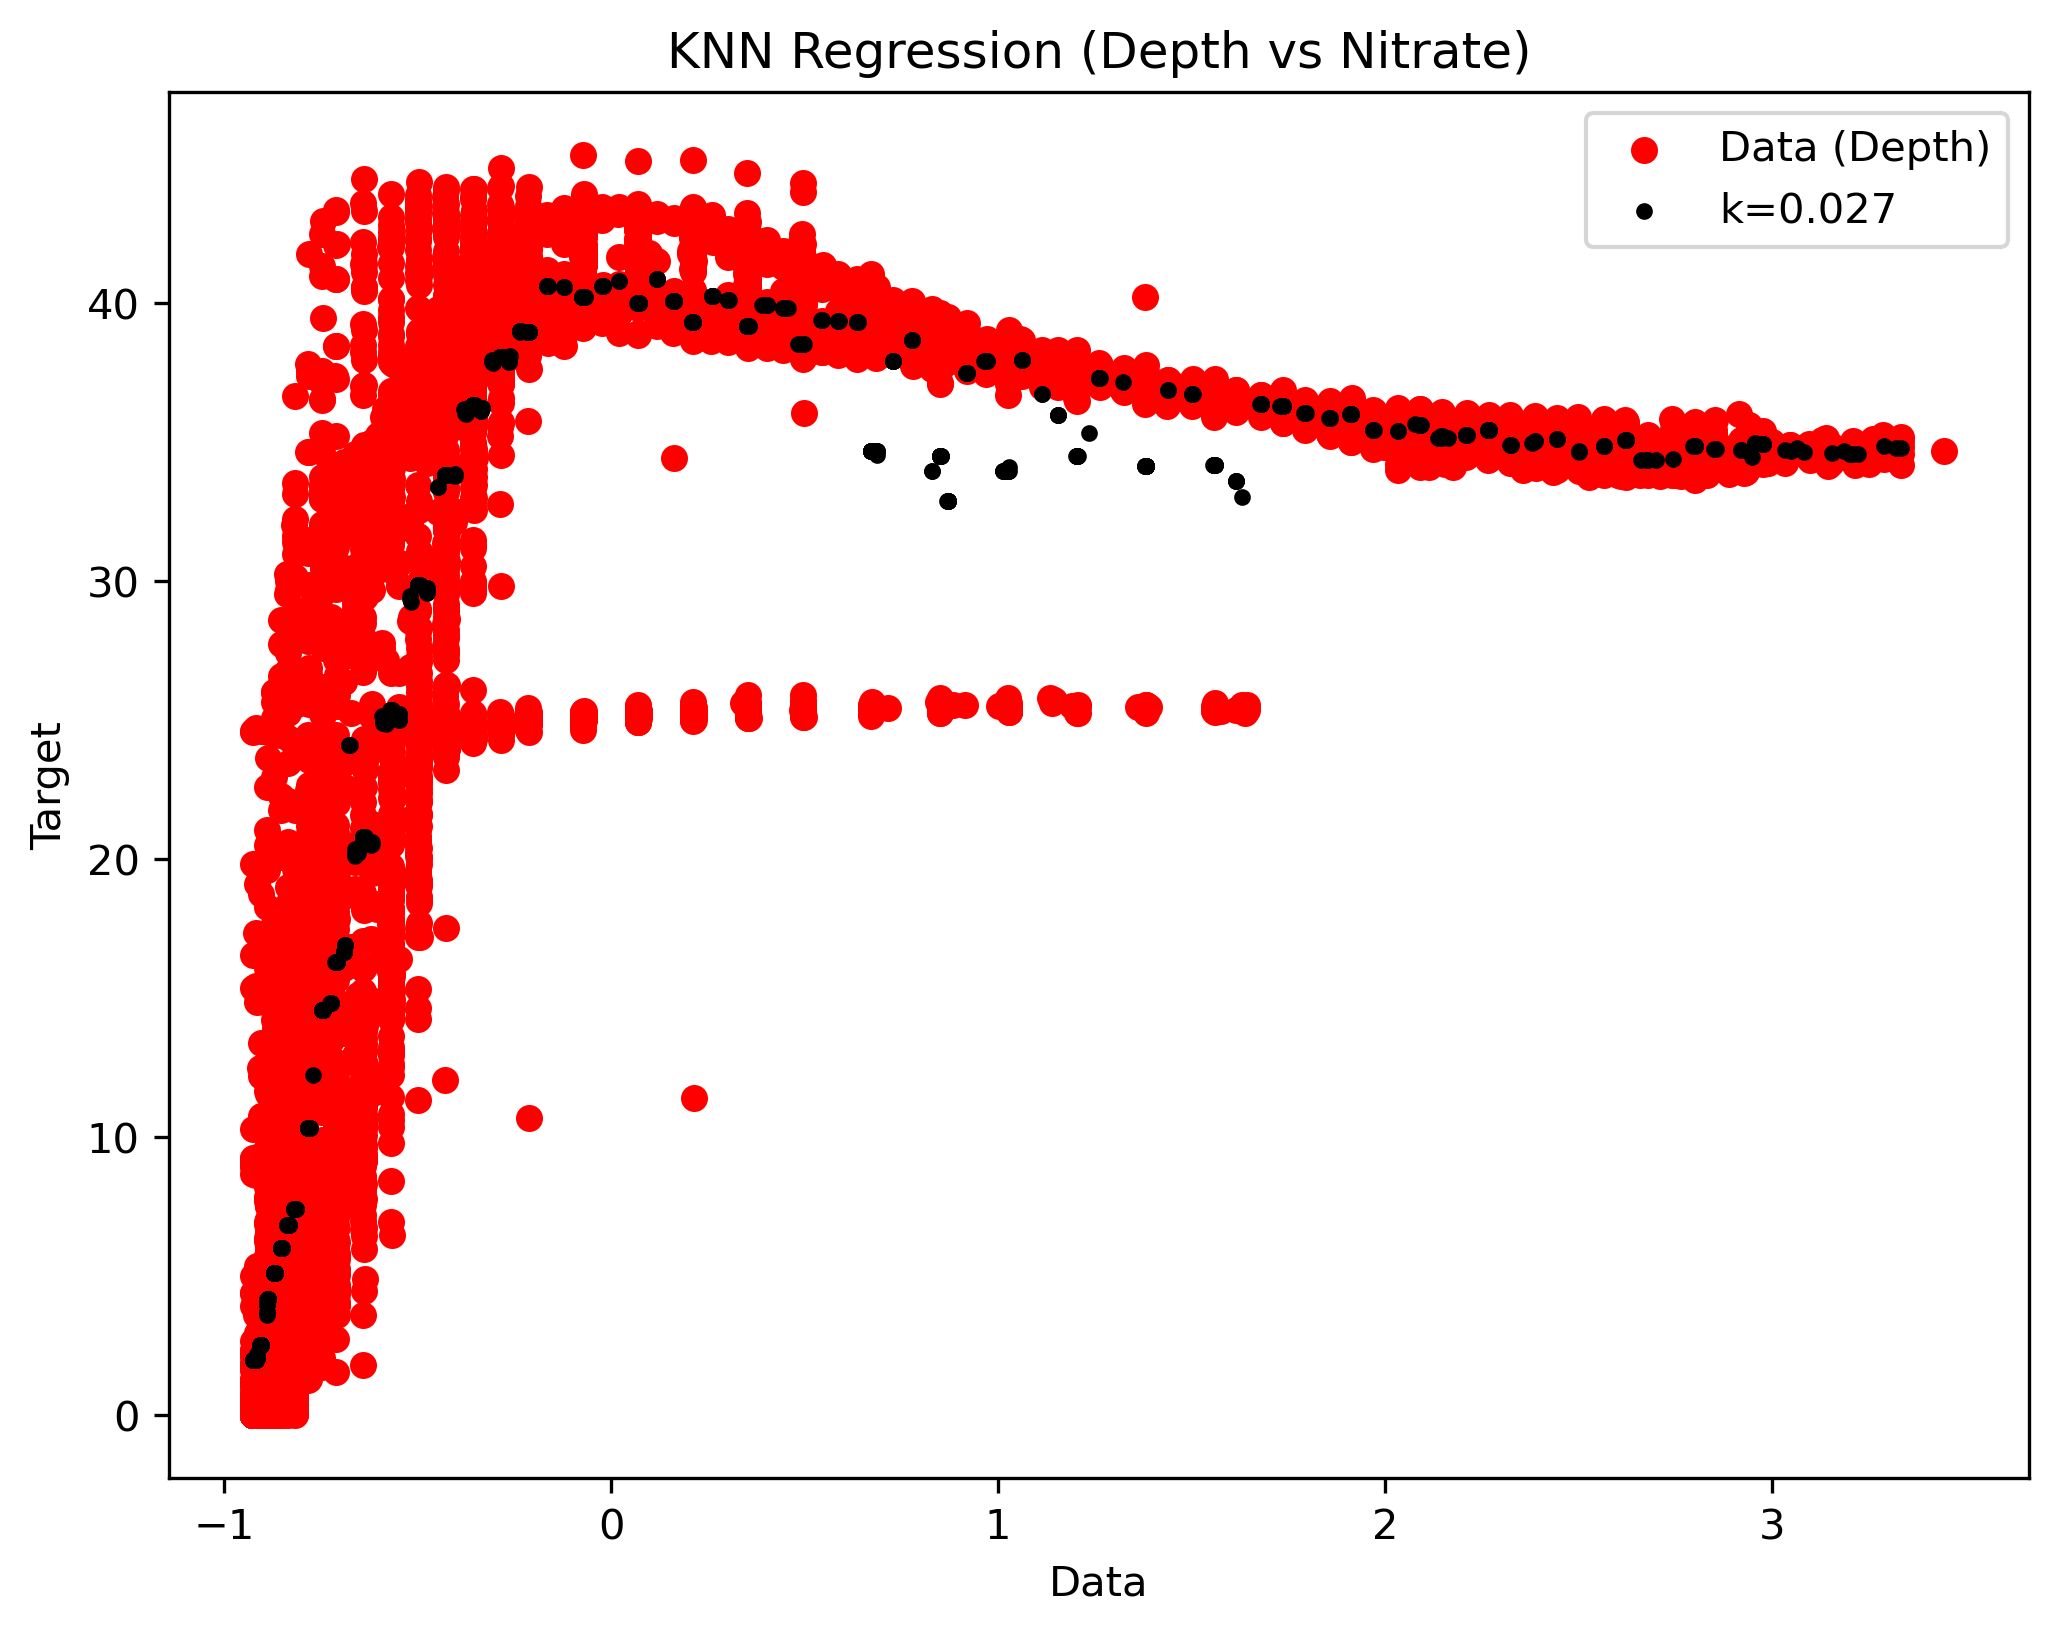

In [38]:
### NONLINEAR DEPTH VS NITRATE
n  = float(input('Choose a number for radius: '))

# Import the necessary modules and libraries
from sklearn.neighbors import RadiusNeighborsRegressor



# Fit regression model
regr_4 = RadiusNeighborsRegressor(radius=n)
regr_4.fit(standXdep_train, ydep_train)
print("R^2 score: {0:.2f}".format(regr_4.score(standXdep_train, ydep_train)))

# Predict (standardized_X_test)
ytest_dep = regr_4.predict(standXdep_test)

# Plot the results
Fig5= plt.figure(figsize = (8,6), dpi = 300)
plt.scatter(standXdep_train, ydep_train, c="red", label="Data (Depth)",s=30)
plt.scatter(standXdep_test, ytest_dep, color="black", label="k="+str(n), s=9)
plt.xlabel("Data")
plt.ylabel("Target")

plt.title("KNN Regression (Depth vs Nitrate)")
plt.legend()
plt.show()
#Fig5.savefig(‘KNNdepth_Reg.png’,format=’png’,dpi=600,transparent=False)

#Best fit r=0.027

In [40]:
##SUMMARY OF JMA MODEL RESULTS

Results={'Variable vs Nitrate':['Temperature','Salinity','Density','Depth','Density & Depth'],'Best Radius (no NaN error)':[0.011,0.091,0.020,0.027,0.14],
        'r2_KNN (Non-Linear)':[0.90,0.35,0.91,0.81,0.95]}
JMAModelResults=pd.DataFrame(Results)
JMAModelResults

#From this Salinity is not the best model to use to predict nitrate-will not use for ARGO dataset
#Density is the most accurate with a KNN r2 value of 0.91. 
#Depth is not as good as Density or Temperature (KNN r2 is only 0.81 at best)
#Depth and density combined is the best model so far!
#Will try out Temperature, Density, and Density/Depth JMA models to predict ARGO nitrate, leaning towards Density/Depth being the most accurate


Variable vs Nitrate  Best Radius (no NaN error)  r2_KNN (Non-Linear)
0         Temperature                       0.011                 0.90
1            Salinity                       0.091                 0.35
2             Density                       0.020                 0.91
3               Depth                       0.027                 0.81
4     Density & Depth                       0.140                 0.95

C:\Users\krist\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


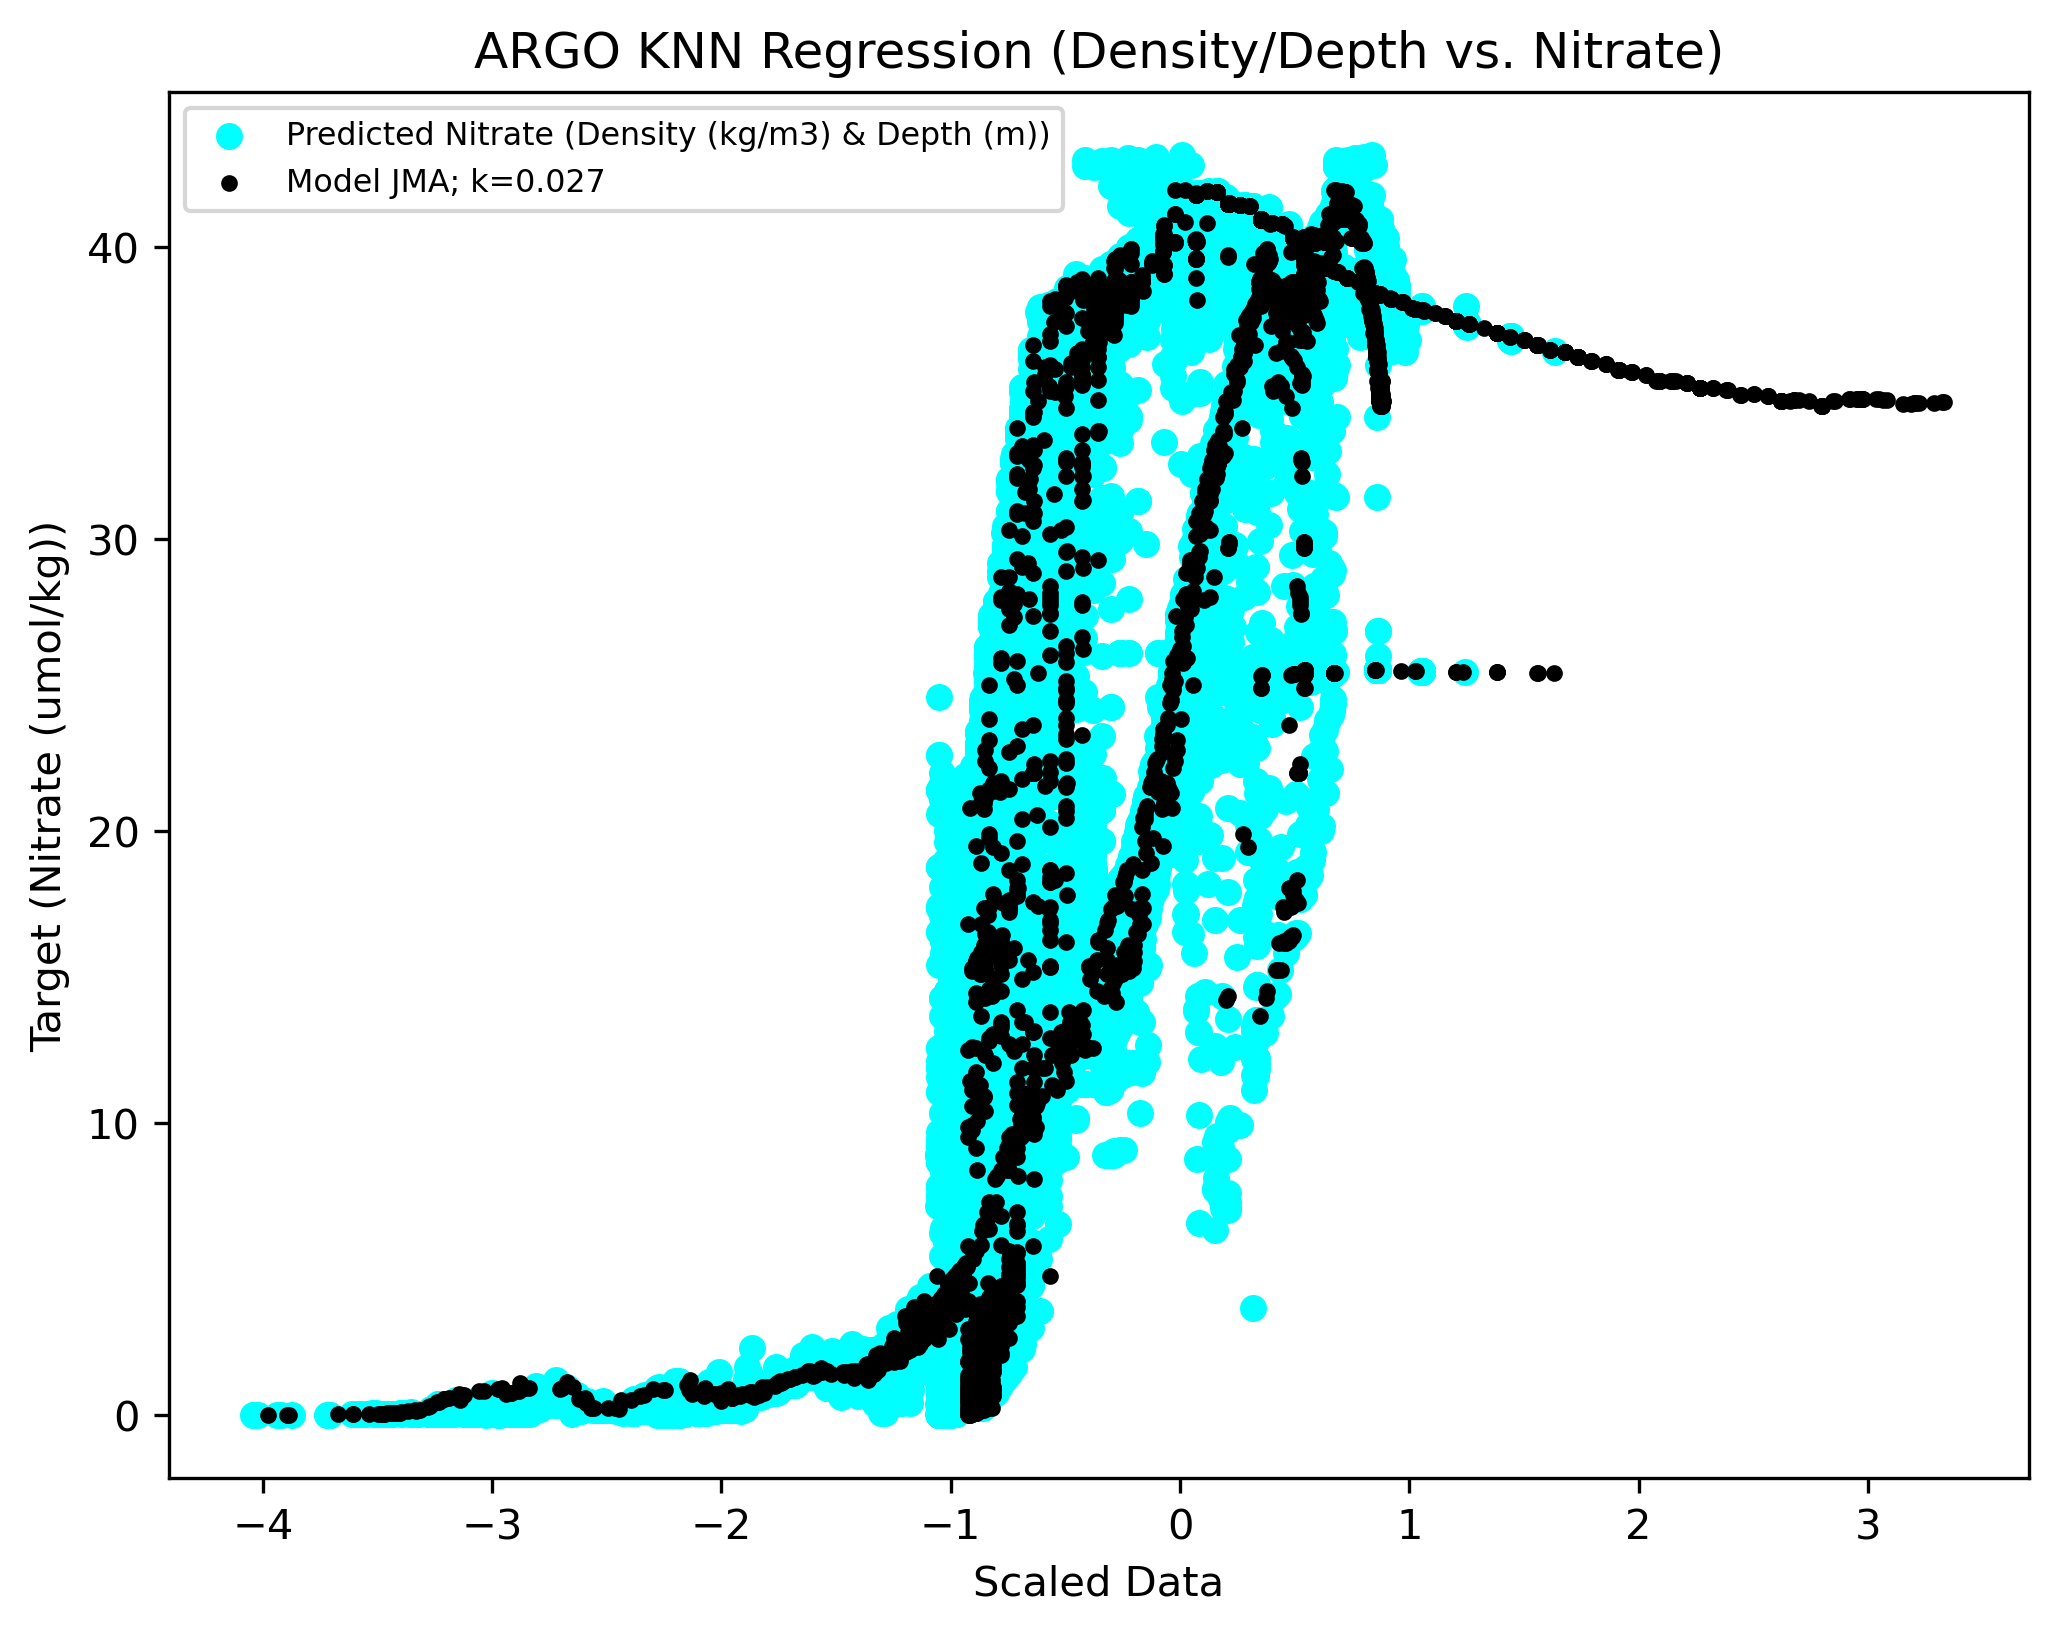

In [41]:
#Use JMA model to predict nitrate in ARGO dataset

#Place KNOWN nitrate data into a serparate variable for later analysis (predict vs experimental nitrate data)
Nitrate_Exp=Data_NO3['NITRATE[uMOL/KG]']
Depth_Exp=Data_NO3['DEPTH[M]']*-1
Temperature_Exp=Data_NO3['TEMPERATURE[C]']
Density_Exp=Data_NO3['SIGMATHETA[KG/M3]']

#Predict new y values (nitrate) based off of model (JMO) using Argo X datapoints (Density & Depth)
ARGODensity=ARGO['SIGMATHETA[KG/M3]']
ARGODepth=ARGO['DEPTH[M]']
DenDepth= ARGO[['SIGMATHETA[KG/M3]','DEPTH[M]']]
DenDepth
scaleDenDepth = StandardScaler().fit(DenDepth)

standXDenDepth = scaleDenDepth.transform(DenDepth)
Nitrate_predictDenDepth = regr.predict(standXDenDepth)

standX_DenDepth=pd.DataFrame(standXDenDepth)
ypredict_DenDepth=pd.DataFrame(Nitrate_predictDenDepth)

#Since there are 2 variables=need to seaprate in order to plot
standXDenDepth1=standX_DenDepth[0]
standXDenDepth2=standX_DenDepth[1]

# Plot the results
Fig6= plt.figure(figsize = (8,6), dpi = 300)
plt.scatter(standXDenDepth1, ypredict_DenDepth, c="cyan", label="Predicted Nitrate (Density (kg/m3) & Depth (m))",s=30)
plt.scatter(standXDenDepth2, ypredict_DenDepth, c="cyan",s=30)

plt.scatter(standX_test1st, ytestpred, color="black", label="Model JMA; k="+str(n), s=9)
plt.scatter(standX_test2nd, ytestpred, color="black",s=9)
plt.xlabel("Scaled Data")
plt.ylabel("Target (Nitrate (umol/kg))")

plt.title("ARGO KNN Regression (Density/Depth vs. Nitrate)")
plt.legend(loc='upper left',prop = {'size' : 7.6})
plt.show()

#Fig6.savefig('PredictedARGONitrate_JMADenDepth.png', bbox_inches='tight', dpi=600)
##StandardScaler warning is ok

#Reason why there is predicting NaN values- ARGO data does not fit within the radius set by the model- to be expected (you can't predict values outside of a known radius)

Text(0.5, 1.0, 'ARGO (Depth vs Nitrate)')

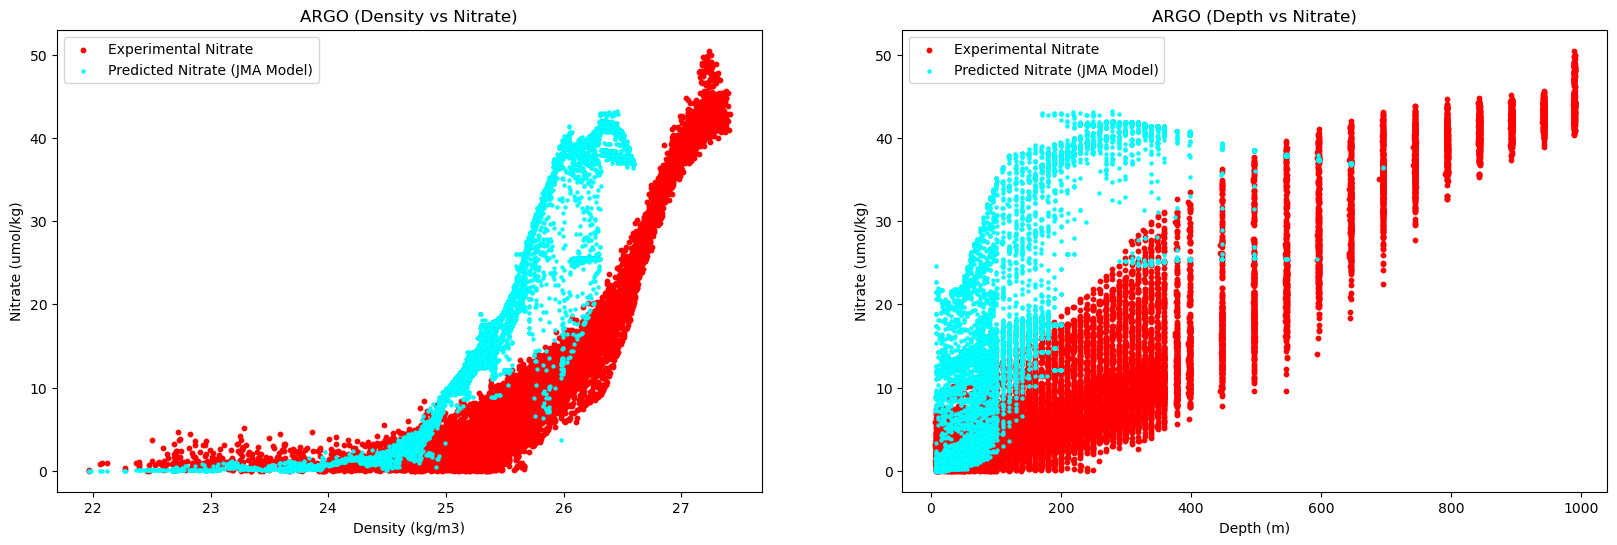

In [42]:
#Compare with known Nitrate values-DENSITY & DEPTH

Fig7= plt.figure(figsize=(20,6))
ax = Fig7.add_subplot(121)
ax2 = Fig7.add_subplot(122)

ax.scatter(Density_Exp, Nitrate_Exp, c="red", label="Experimental Nitrate",s=10)
ax.scatter(ARGODensity, ypredict_DenDepth, c="cyan",edgecolors='black',linewidth=0.01,s=10,label="Predicted Nitrate (JMA Model)")
ax.legend()
ax.set_xlabel("Density (kg/m3)")
ax.set_ylabel("Nitrate (umol/kg)")
ax.set_title("ARGO (Density vs Nitrate)")



ax2.scatter(Depth_Exp, Nitrate_Exp, c="red", label="Experimental Nitrate",s=10)
ax2.scatter(ARGODepth, ypredict_DenDepth, c="cyan",edgecolors='black',linewidth=0.01,s=10,label="Predicted Nitrate (JMA Model)")
ax2.legend()
ax2.set_xlabel("Depth (m)")
ax2.set_ylabel("Nitrate (umol/kg)")
ax2.set_title("ARGO (Depth vs Nitrate)")

#Fig7.savefig('PredictedARGONitrate_DepDen.png', bbox_inches='tight', dpi=600)

#The predicted nitrate was only accurate for certain ranges for both density and depth (when making a model with both parameters) when compared 
#to the actual ARGO values (for both Nitrate values below 10 umol/kg fell within expected Nitrate ranges)
#Some predicted values did fit within the expected values (Around Density 26 kg/m3 there are expected values fitting in the 15 umol/kg range)
#However There is a lot of predicted values that do not fit within the expected range- outliers above Density @ 25 kg/m3, and above 200 m
#using both density and depth for the JMA model does not accurately predict ARGO nitrate concentrations :(
#Different depth and density ranges for both data sets- even though JMA covered more ground than ARGO, the ranges seem to not overlap as well as I had originally thought :(
#scaled y values were plotted with unscaled x varaibles to be able to overlay expected nitrate values as well- could affect the range too?


In [43]:
## R-2 and RMSE- can't have any NaN values from predicted
#Put x values from ARGO and predicted y nitrate into a data frame to drop NaN, then put them back into an array for analysis
##Do for both density & depth all together
combinedDDy=standX_DenDepth.join(ypredict_DenDepth, lsuffix='Den',rsuffix='Y')

DenDepY_noNA=combinedDDy.dropna()
DenDepY_noNA.columns = ["Den", "Dep","Y"]
DenDepY_noNA

x1=DenDepY_noNA['Den']
x2=DenDepY_noNA['Dep']
y_cor1=DenDepY_noNA['Y']
y_cor2=DenDepY_noNA['Y']

xtotals=np.column_stack((x1,x2))
ytotals=np.column_stack((y_cor1,y_cor2))

RMSEDepDen=np.sqrt(mean_squared_error(xtotals,ytotals))
R2DepDen=regr.score(xtotals,y_cor1)

print('RMSE =',(RMSEDepDen))
print("R^2 score: {0:.3f}".format(R2DepDen))



RMSE = 21.555873299320588
R^2 score: 1.000


C:\Users\krist\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\neighbors\_regression.py:470: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


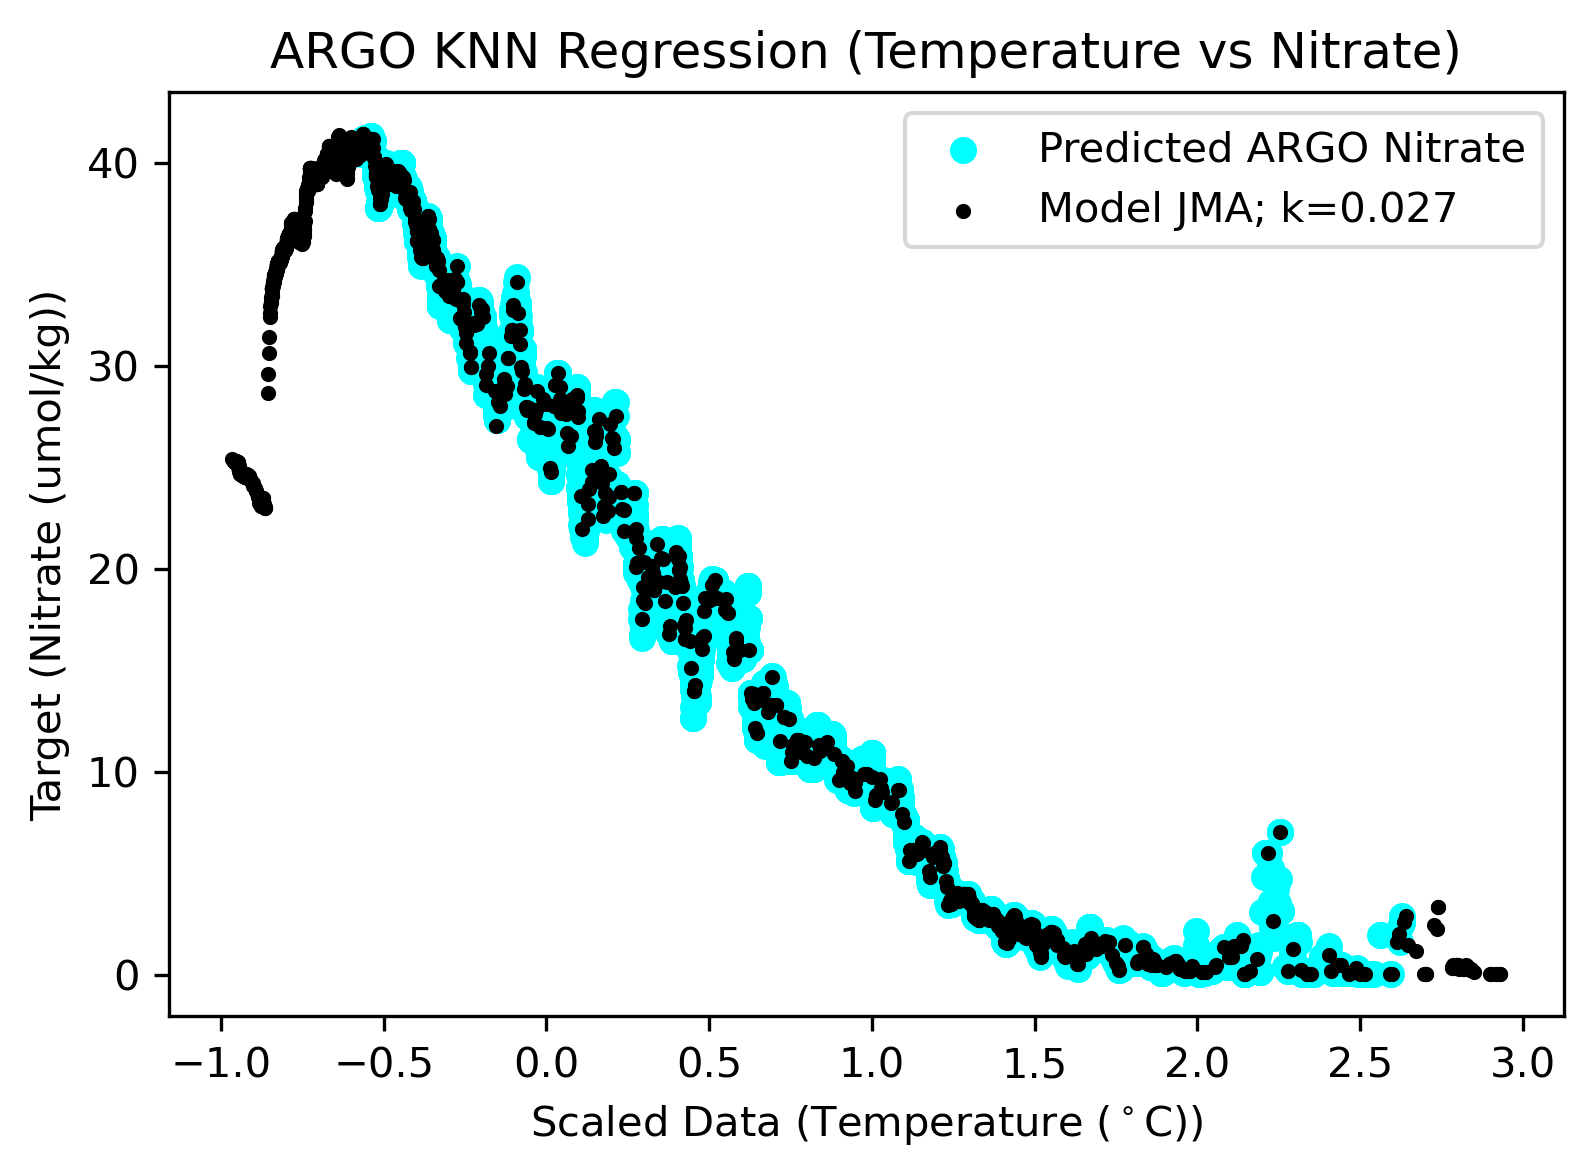

In [44]:
#Use JMA model to predict nitrate in ARGO dataset

#Predict new y values (nitrate) based off of model (JMO) using Argo X datapoints (Temperature)

ARGOTemp=ARGO['TEMPERATURE[C]']
at=np.array(ARGOTemp, dtype=np.float32)
atemp=np.reshape(at,(-1,1))
atemp
scaleTemp = StandardScaler().fit(Xtemp_train)
standXtemp = scaleTemp.transform(atemp)
Nitrate_predictTemp = regr_1.predict(standXtemp)

# Plot the results
Fig8= plt.figure(figsize = (6,4), dpi = 300)
plt.scatter(standXtemp, Nitrate_predictTemp, c="cyan", label="Predicted ARGO Nitrate",s=30)
plt.scatter(standXtemp_test, ytest_temp, color="black", label="Model JMA; k="+str(n), s=7)
plt.xlabel("Scaled Data (Temperature ($^\circ$C))")
plt.ylabel("Target (Nitrate (umol/kg))")

plt.title("ARGO KNN Regression (Temperature vs Nitrate)")
plt.legend()
plt.show()

#Fig8.savefig('PredictedARGONitrate_JMATemp.png', bbox_inches='tight', dpi=600)
##StandardScaler warning is ok

#Reason why there is predicting NaN values- ARGO data does not fit within the radius set by the model- to be expected (you can't predict values outside of a known radius)

In [45]:
## R-2 and RMSE- can't have any NaN values from predicted
#Put xtemp values from ARGO and predicted y nitrate into a data frame to drop NaN, then put them back into an array for analysis
X=pd.DataFrame(standXtemp)

Y=pd.DataFrame(Nitrate_predictTemp)

combined=X.join(Y, lsuffix='X', rsuffix='Y')
PredTempnoNan=combined.dropna()

x=PredTempnoNan['0X']
y=PredTempnoNan['0Y']
xval=np.array(x, dtype=np.float32)
yval=np.array(y, dtype=np.float32)
tempx=np.reshape(xval,(-1,1))
tempy=np.reshape(yval,(-1,1))

RMSEtemp=np.sqrt(mean_squared_error(tempx,tempy))
R2temp=regr_1.score(tempx,tempy)

print("R^2 score: {0:.3f}".format(R2temp))
print('RMSE =',(RMSEtemp))

R^2 score: 1.000
RMSE = 17.94036


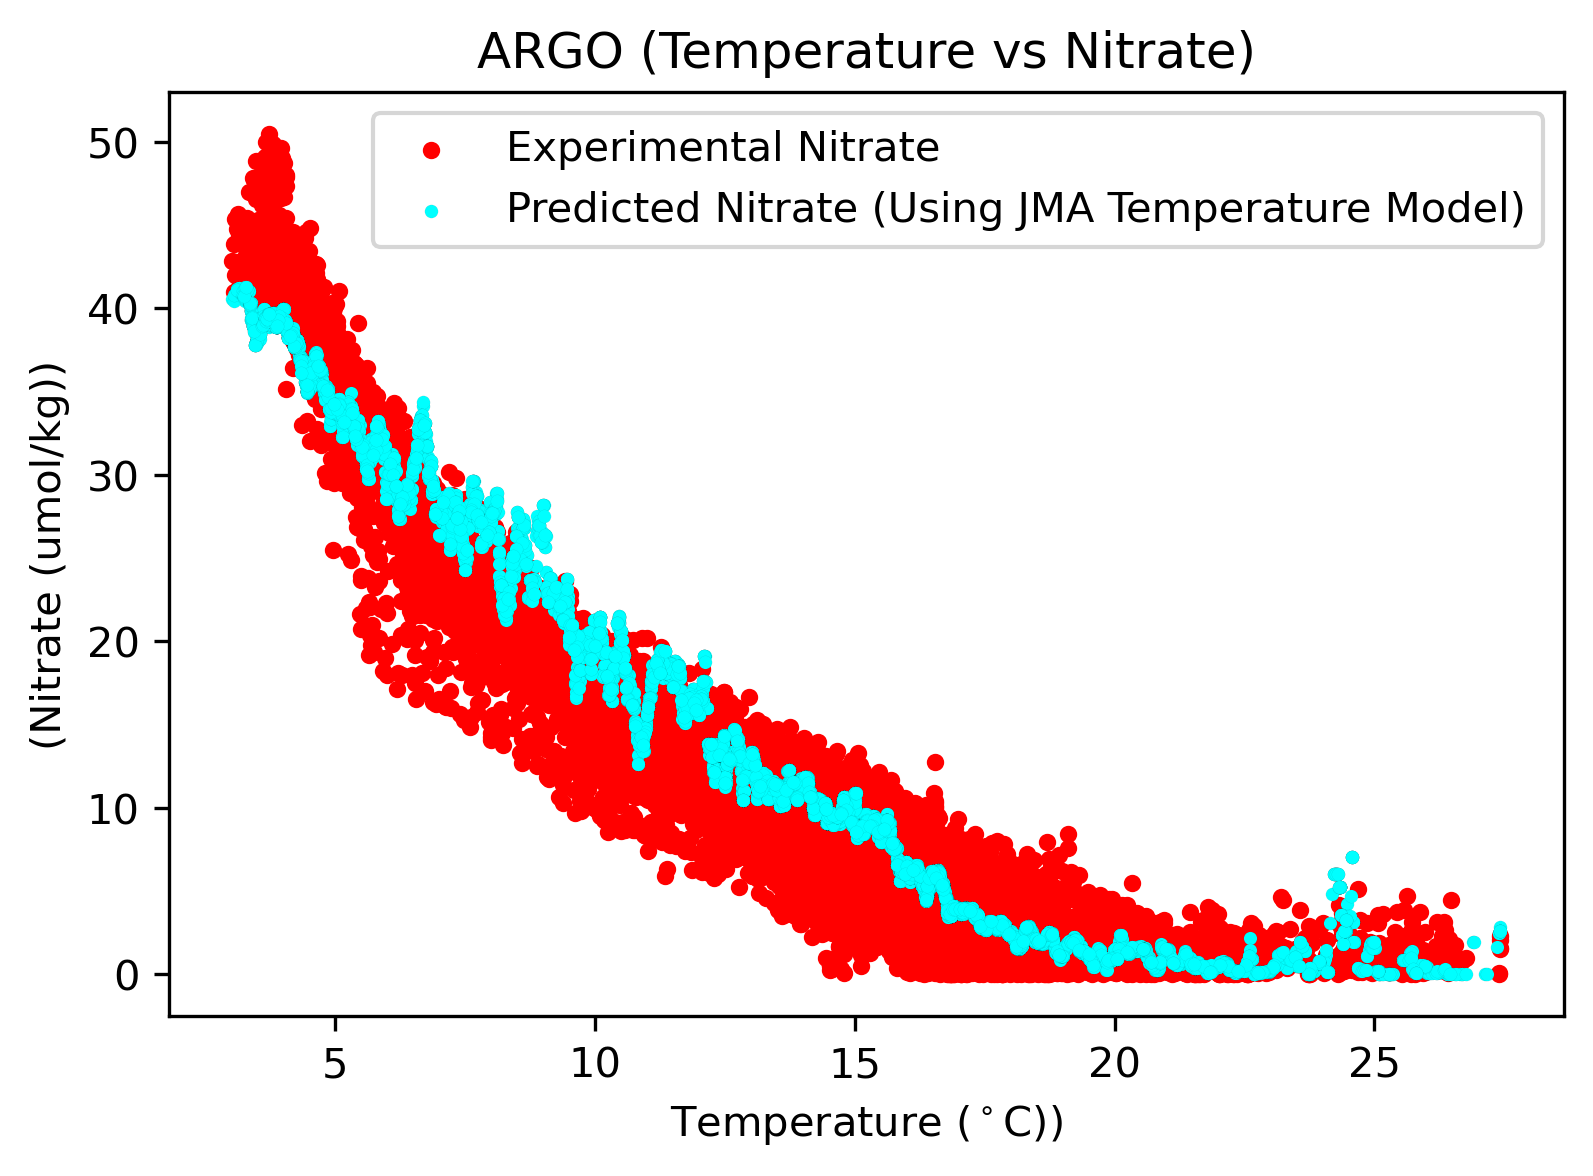

In [46]:
#Compare with known Nitrate values-TEMPERATURE
Fig9= plt.figure(figsize = (6,4), dpi = 300)
plt.scatter(Temperature_Exp, Nitrate_Exp, c="red", label="Experimental Nitrate",s=10)
plt.scatter(ARGOTemp, Nitrate_predictTemp, c="cyan", edgecolors='black',linewidth=0.01,label="Predicted Nitrate (Using JMA Temperature Model)",s=10)
plt.xlabel("Temperature ($^\circ$C))")
plt.ylabel("(Nitrate (umol/kg))")
plt.title("ARGO (Temperature vs Nitrate)")
plt.legend()
plt.show()
#Fig9.savefig('PredictedARGONitrate_Temp.png', bbox_inches='tight', dpi=600)


C:\Users\krist\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


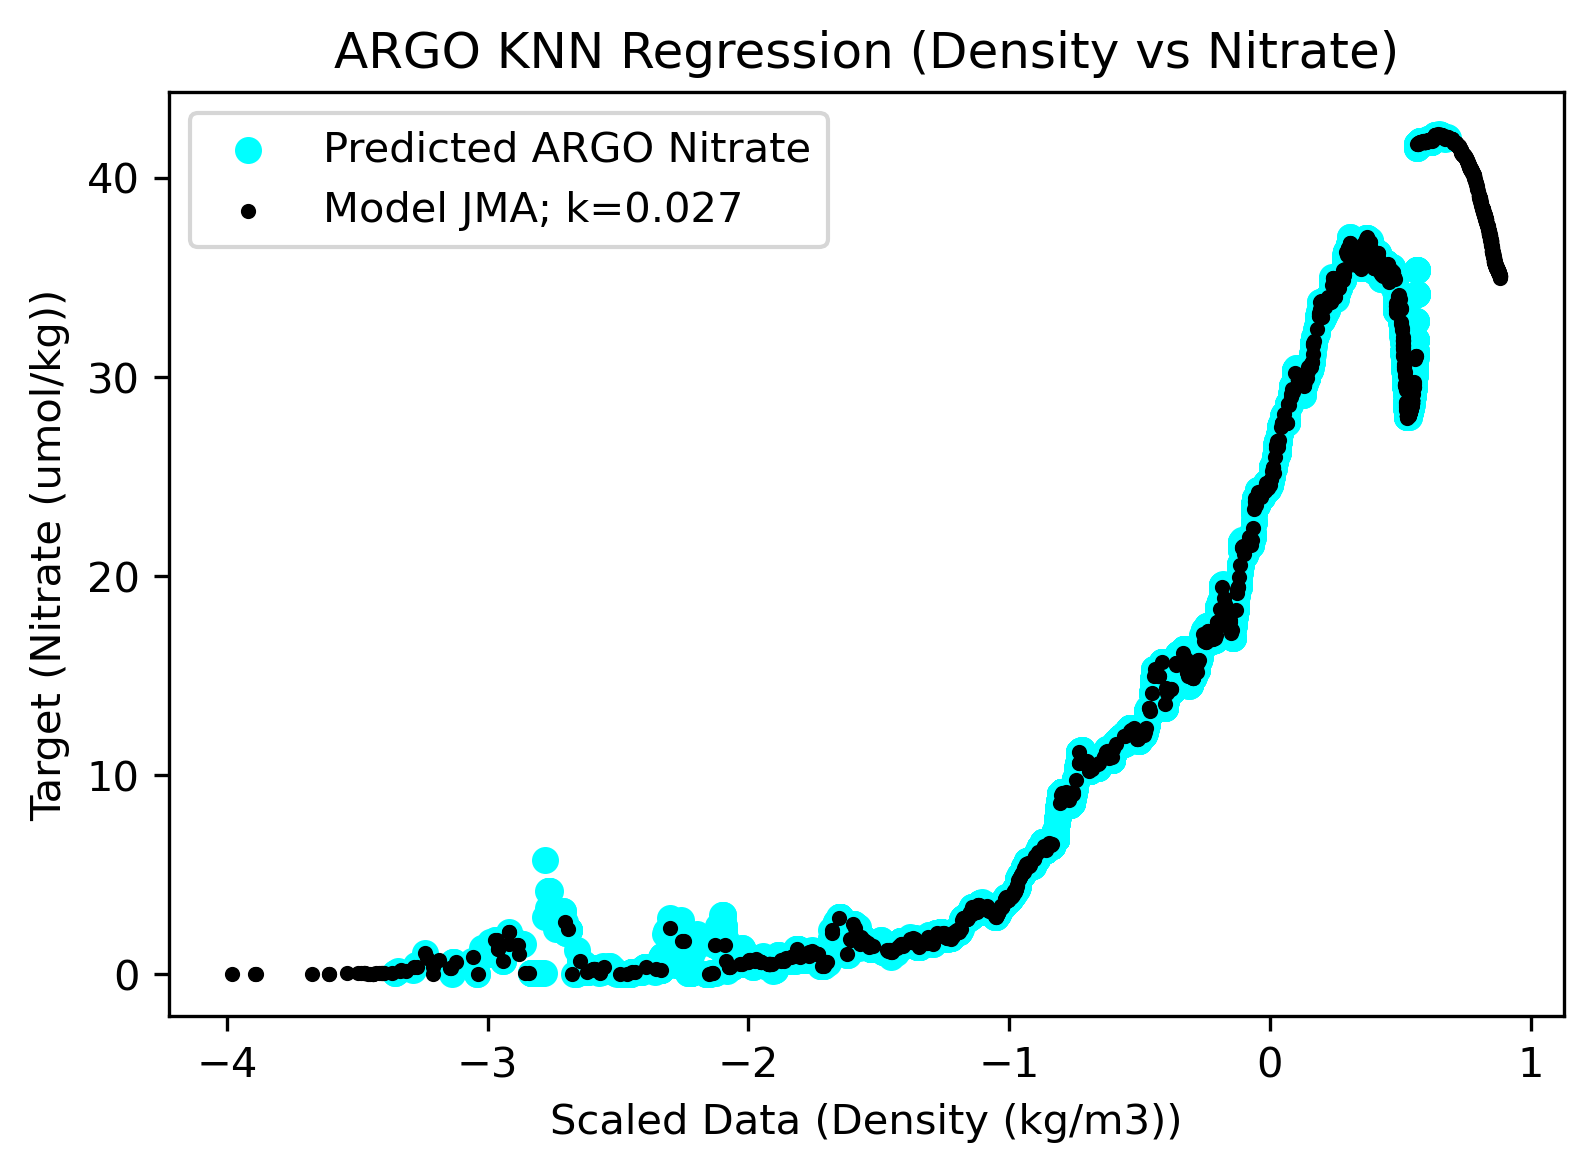

In [47]:
#Use JMA model to predict nitrate in ARGO dataset

#Predict new y values (nitrate) based off of model (JMO) using Argo X datapoints (Density)
ARGODen=ARGO['SIGMATHETA[KG/M3]']
ad=np.array(ARGODen, dtype=np.float32)
aden=np.reshape(ad,(-1,1))
aden

scaleDen = StandardScaler().fit(Xden_train)
standXden = scaleDen.transform(aden)
Nitrate_predictDen = regr_3.predict(standXden)

# Plot the results
Fig10= plt.figure(figsize = (6,4), dpi = 300)
plt.scatter(standXden, Nitrate_predictDen, c="cyan", label="Predicted ARGO Nitrate",s=30)
plt.scatter(standXden_test, ytest_den, color="black", label="Model JMA; k="+str(n), s=7)
plt.xlabel("Scaled Data (Density (kg/m3))")
plt.ylabel("Target (Nitrate (umol/kg))")

plt.title("ARGO KNN Regression (Density vs Nitrate)")
plt.legend()
plt.show()

#Fig10.savefig('PredictedARGONitrate_JMADen.png', bbox_inches='tight', dpi=600)

In [48]:
##R-2 and RMSE- can't have any NaN values from predicted
#Put xden values from ARGO and predicted y nitrate into a data frame to drop NaN, then put them back into an array for analysis
Xd=pd.DataFrame(standXden)
Yd=pd.DataFrame(Nitrate_predictDen)
combine=Xd.join(Yd, lsuffix='X', rsuffix='Y')
PredDennoNan=combine.dropna()
xd=PredDennoNan['0X']
yd=PredDennoNan['0Y']
xdval=np.array(xd, dtype=np.float64)
ydval=np.array(yd, dtype=np.float64)
denx=np.reshape(xdval,(-1,1))
deny=np.reshape(ydval,(-1,1))

RMSEdensity=np.sqrt(mean_squared_error(denx,deny))
R2density=regr_3.score(denx,deny)
print("R^2 score: {0:.3f}".format(R2density))
print('RMSE =',RMSEdensity)


R^2 score: 1.000
RMSE = 18.188391680811346


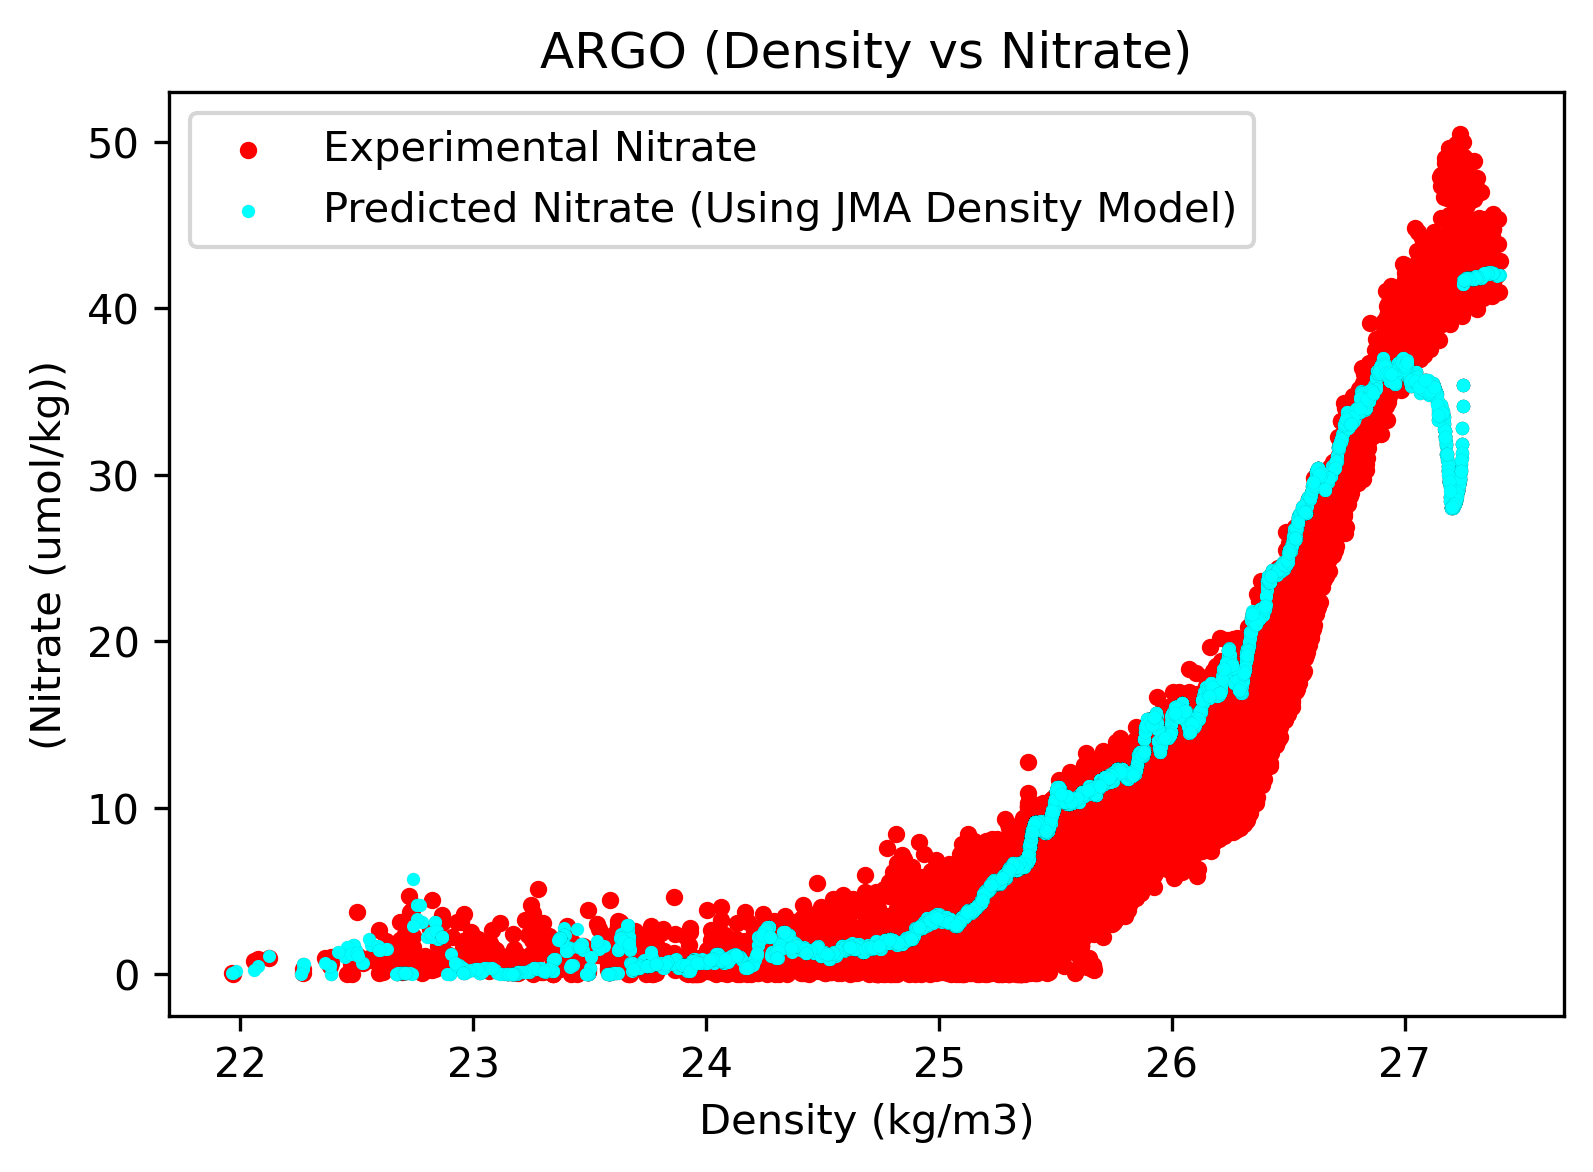

In [49]:
#Compare with known Nitrate values-DENSITY
Fig11= plt.figure(figsize = (6,4), dpi = 300)
plt.scatter(Density_Exp, Nitrate_Exp, c="red", label="Experimental Nitrate",s=10)
plt.scatter(ARGODen, Nitrate_predictDen, c="cyan", edgecolors='black',linewidth=0.01,label="Predicted Nitrate (Using JMA Density Model)",s=10)
plt.xlabel("Density (kg/m3)")
plt.ylabel("(Nitrate (umol/kg))")
plt.title("ARGO (Density vs Nitrate)")
plt.legend()
plt.show()
#Fig11.savefig('PredictedARGONitrate_Den.png', bbox_inches='tight', dpi=600)


In [50]:
##SUMMARY OF ARGO PREDICTIONS #Values from above cells

Results={'Variable vs Nitrate':['Temperature','Density','Density & Depth'],'R^2 (no NaNs)':[R2temp,R2density,R2DepDen],
        'RMSE':[RMSEtemp,RMSEdensity,RMSEDepDen]}
JMAModelResults=pd.DataFrame(Results)
JMAModelResults

# R2 value of 1 for temperature,density,and density & depth together means that the JMA model predicts the ARGO nitrate values well
# However the RMSE (Average distance between the predicted values from the model and the actual values in the dataset-residuals!) is relatively large
# Surprised that temperature had a lower RMSE than density- 
#this means that the Temperature JMA model is better than the Density JMA model in terms of predicting ARGO nitrate values
#For density- (ARGO nitrate values abov 45 umol/kg) the JMA model did not have a lot of values above this range, density was also on a fixed range

#The predicted nitrate was only accurate for certain ranges for density and depth together (when making a model with both parameters) when compared 
#to the actual ARGO values (for both Nitrate values below 10 umol/kg fell within expected Nitrate ranges)
#Some predicted values did fit within the expected values (Around Density 26 kg/m3 there are expected values fitting in the 15 umol/kg range)
#However There is a lot of predicted values that do not fit within the expected range- outliers above Density @ 25 kg/m3, and above 200 m
#using both density and depth for the JMA model does not accurately predict ARGO nitrate concentrations :(
#Different depth and density ranges for both data sets- even though JMA covered more ground than ARGO, the ranges seem to not overlap as well as I had originally thought :(
#scaled y values were plotted with unscaled x varaibles to be able to overlay expected nitrate values as well- could affect the range too?

#Outliers
#Temperature: -3 standardized /~22.9 C mark-slightly above the expected.
#Density outlier more noticable: 0.5 standardized/27 mark, lower than the expected.
#This is because we based off the model on JMA- covers different latitudes & longitudes
#Than ARGO data, even though there is some overlap those points did not fit the radius 
#best fitted for the JMA model.
#There was some NaN errors for temperature- meaning that some of the ARGO data points
#Did not fit in the JMA model.
# This means some of the ARGO datapoints don't fit within the best fit radius.
# If we were to increase the radius to include those data points, a trade off
# would be that the best fit (R2) in the JMA model would decrease.


Variable vs Nitrate  R^2 (no NaNs)       RMSE
0         Temperature            1.0  17.940359
1             Density            1.0  18.188392
2     Density & Depth            1.0  21.555873

In [48]:
#SUMMARY OF WORK

## EDA
# JMA
#Standard deviation quite huge for temperature, depth, density and nitrate- means there is variation in those variables
#Salinity standard deviation is smaller, so less variation

# ARGO
#Standard deviation quite huge for depth, pressure, and temperature. This means there is huge #variation in those variables
#Salinity and density standard deviation is smaller, so less variation

#From what we observe- The ARGO ranges of depth, salinity, temperature, and density fall within the JMA ranges.
#This is good because this means we can use the JMA model we will create to predict NO3 values in ARGO that can fit within the training & test data

# Geographic Overlap
#From this figure, we can see that JMA sampling covers a lot of area, while ARGO is confined to a latitude range (28-38)
#There is some overlap at the 150 E, 36 N and 164 E, 36 N areas.
#The years for each dataset do not overlap- basically we would be using the model to predict #nitrate concentration in future years
#(Will help with model accurracy and precison!)
#Some ARGO data may not fit in the radius we set in our JMA model!


# TS Diagram
#Comparing the TS diagrams of both datasets- JMA has a wider range than ARGO, ARGO is more confined. This is good, since the density vs nitrate model
#derived from JMA would cover more ground/increase accuracy & precision of Argo
#Makes sense since JMA as a wider range (latitude & longitude) of sampling sites/larger water mass covered
#Could also mean they are sampled from different water masses

# JMA Variables vs Salinity plots
#Since temperature and salinity are related to density, could build a model just off of density.
#Depth doesn't have a linear relationship-hard to graph
#Check if normal distrubution

# Histogram (parametric vs non-parametric)
#None of the JMA variables are normally distributed based off of histogram 
#Depth- left skewed- lots of surface sampling
#Density- right skewed
#Temperature & Nitrate- Bimodal
#Salinity-almost looks like a gaussian curve but slightly skewed to the right. This value makes sense however since typical values should be between
# 34 ppt-36 ppt. Since the other data is not normally distributed, we have to use non-parametric testing anyway.

#Could also do Qualtile-Qualtile Plot or Shapiro-Wilk tests to double check but it's obvious by looking at the data visually with the histograms
#Data is nonparametric! Requires nonparametric testing

# Non-Parametric Correlation Tests- adapted from HW2 (Confesor)
#Spearman's Correlation coefficient is used 
# This summarizes strength between two data samples. Calculated via relative rank of values for each sample
#looking at correlations between nitrate & other variables

#All were significant using nonparametric testing
#As Density increases, Nitrate increases
#Depth increases, Nitrate increases (between 0 m to 1000 m there is a sharp incline then it levels out
#Temperature increases, Nitrate decreases
#Salinity increases, Nitrate decreases (harder to see this relationship visually-take with a grain of salt as 
#salinity did not go below 18)

## Model building with JMA data

#From this Salinity is not the best model to use to predict nitrate-will not use for ARGO dataset
#Depth and density combined is the best model so far (KNN r2=0.95)
#Density is 2nd best with KNN r2 value of 0.91. 
#Depth is not as good as Density or Temperature (KNN r2 is only 0.81 at best)
#Will try out Temperature, Density, and Density/Depth JMA models to predict ARGO nitrate, leaning towards Density/Depth being the most accurate

## Predicting ARGO nitrate values with JMA model
#Reason why there is predicted NaN values- ARGO data does not fit within the radius set by the model- this is expected (you can't predict values outside of a known radius)
# R2 value of 1 for temperature, density, and density & depth together means that the JMA model predicts the ARGO nitrate values well
# However the RMSE (Average distance between the predicted values from the model and the actual values in the dataset-residuals!) is relatively large for all trials
# Surprised that temperature had a lower RMSE than density/depth together 
#this means that the Temperature JMA model is better than the Density/Depth JMA model in terms of predicting ARGO nitrate values, although having 2 parameters to make a model is more realistic.
#For density only- (ARGO nitrate values abov 45 umol/kg) the JMA model did not have a lot of values above this range, density was also on a fixed range

#Outliers

#The predicted nitrate was only accurate for certain ranges for density and depth together (when making a model with both parameters) when compared 
#to the actual ARGO values (for both Nitrate values below 10 umol/kg fell within expected Nitrate ranges)
#Some predicted values did fit within the expected values (Around Density 26 kg/m3 there are expected values fitting in the 15 umol/kg range)
#However, there is a lot of predicted values that do not fit within the expected range- outliers above Density @ 25 kg/m3, and above 200 m
#using both density and depth for the JMA model does not accurately predict ARGO nitrate concentrations even if it is more realistic :(
#This is due to different depth and density ranges for both data sets-
#even though JMA covered more ground than ARGO, the ranges seem to not overlap as well as we had originally thought :(
#scaled y values were plotted with unscaled x varaibles to be able to overlay expected nitrate values as well- potentially affect the range too

#Temperature: -3 standardized /~22.9 C mark-slightly above the expected.
#Density: 0.5 standardized/27 mark, lower than the expected.
#This is because we based off the model on JMA- 
#JMA covers different latitudes & longitudes than the ARGO data, 
#even though there is some overlap those points did not fit the radius  best fitted for the JMA model.
#There was some NaN errors for temperature- meaning that some of the ARGO data points
#did not fit in the JMA model.

#This means some of the ARGO datapoints don't fit within the best fit radius.
#If we were to increase the radius to include those data points, a trade off would be that the best fit (R2) in the JMA model would decrease.
#Perhaps the model we made is too overfitted? The JMA r2 value wasn't a perfect 100% though.
#Future studies- look at other datasets in the region to see of JMA is still a good model for predicting Nitrate